In [51]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_darrays as uda
import datetime
# import salem
# from salem import get_demo_file, DataLevels, GoogleVisibleMap, Map
import shapely.geometry as shpg
import glob
import pickle as pkl
import os
from scipy.stats import binned_statistic_2d, binned_statistic
from scipy import stats
from endgame import hist2d



pylab.rcParams['figure.figsize'] = (10., 5.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
for ids, y in enumerate(range(2000,2021)):
    #'ipdb.set_trace()
    try:
        test = pd.read_csv(glob.glob('/media/ck/LStorage/global_water/MCS_5000km2_tables/EAfrica/'+str(y)+'*.csv')[0])
    except:
        ipdb.set_trace()
#         test = pd.read_csv(glob.glob('/media/ck/LStorage/global_water/save_files_v2/'+regs+'_mcs_tracks_final_'+str(y)+'*.csv')[0])
    if ids == 0:
        test2 = pd.DataFrame(test)
    else :
        test2 = pd.concat([test2, test])

In [4]:
test2.keys()

Index(['Unnamed: 0', 'date', 'month', 'hour', 'minute', 'year', 'day', 'area',
       '70area', 'tmin', 'minlon', 'minlat', 'maxlon', 'maxlat', 'clon',
       'clat', 'tminlon', 'tminlat', 'tmean', 'tp1', 'tp99', 'stormID',
       'precipitation_mean', 'precipitation_max', 'precipitation_p95',
       'precipitation_p99'],
      dtype='object')

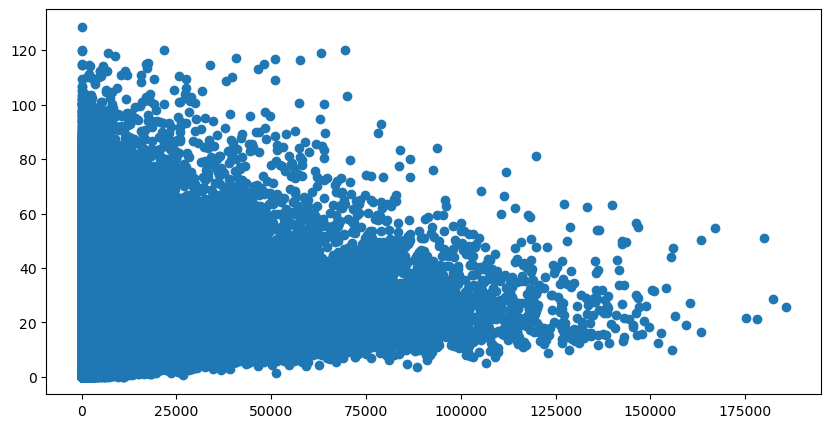

In [9]:
plt.scatter(test2['70area'], test2['precipitation_max'])

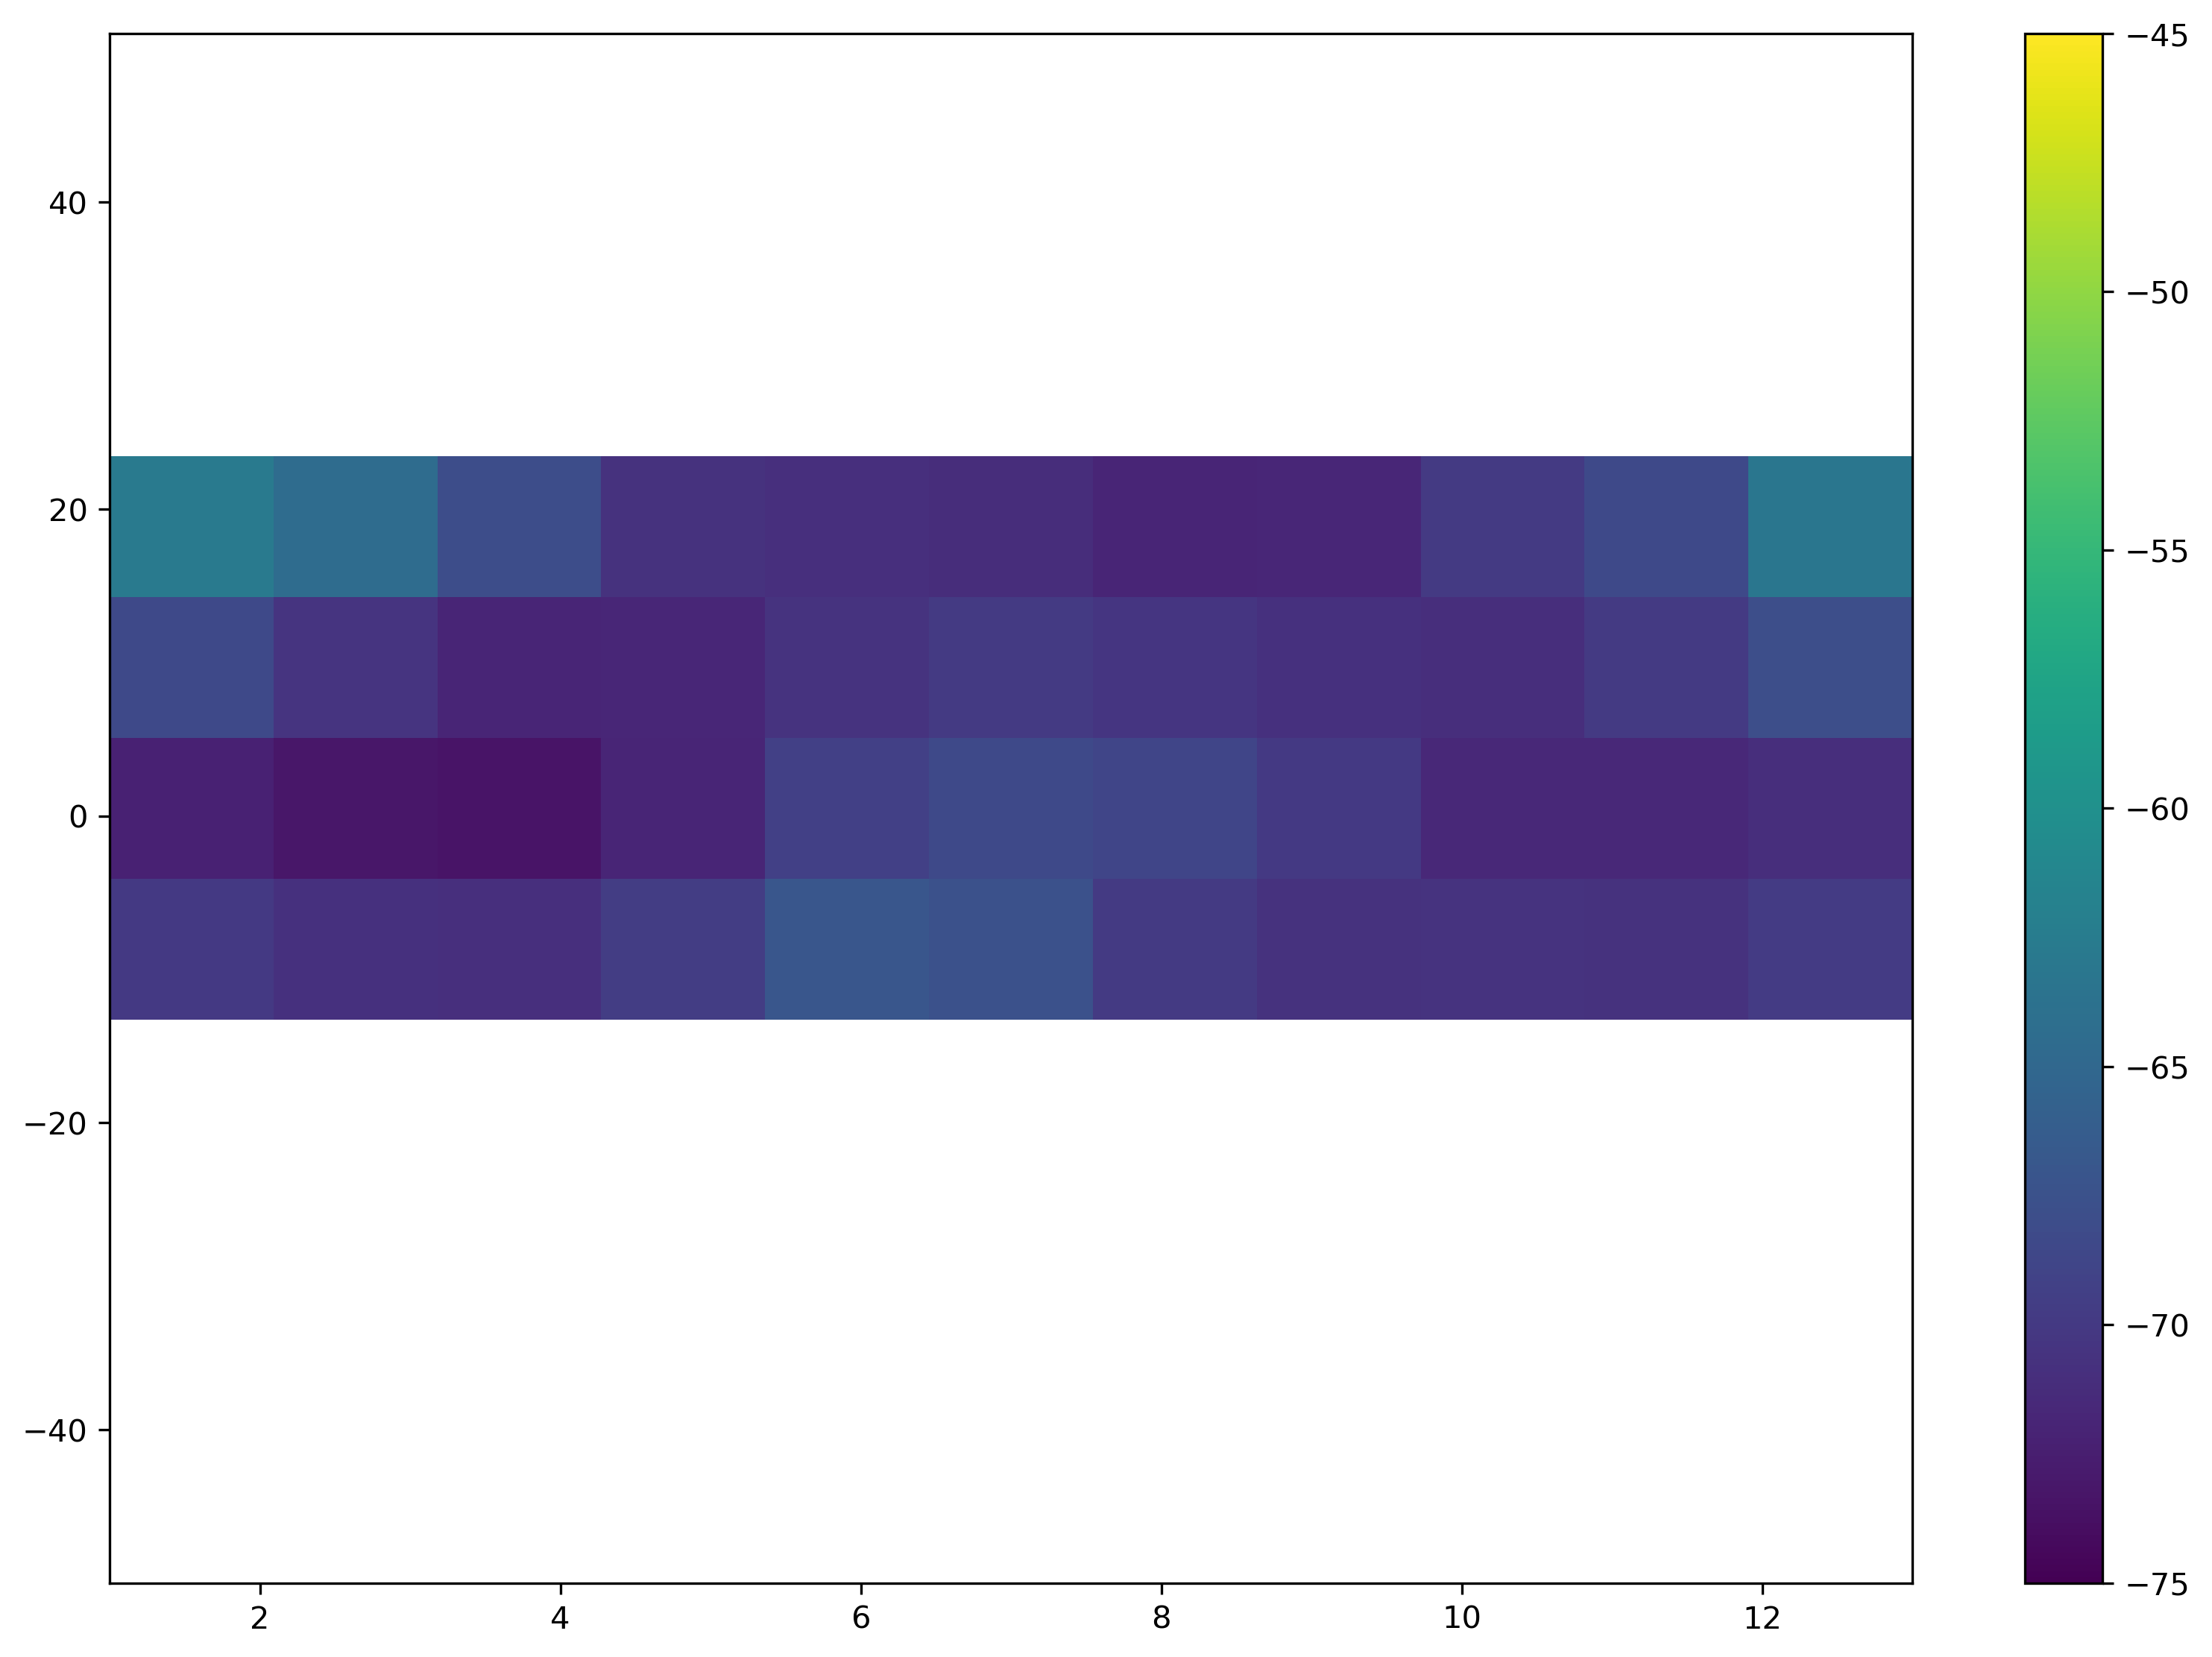

In [15]:
f= plt.figure(figsize=(13,9), dpi=300)

ax = f.add_subplot(111)

pick = test2
tbin = np.linspace(-50,51,12)
sbin = np.linspace(1,13,12)

testbins = [sbin,tbin]
func1 = lambda y: np.mean(y) #np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
func2 = lambda y: np.sum(np.isfinite(y))
func3 = lambda y: np.sum(y>1)

xxu2 = pick['month'].values.astype(np.float64)
xxtc = pick['clat'].values
xxch = pick['tmin'].values

# ipdb.set_trace()

ret = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func1, bins=testbins)
# count = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func2, bins=testbins)
# thresh = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func3, bins=testbins)

dd=ret.statistic.T

mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap='viridis', vmin=-75, vmax=-45) #vmax=p2-1, vmin=0.5  ##p2-1
#plt.title(regs+' IQR ='+str(np.round(np.nanpercentile(xxch,75)-np.nanpercentile(xxch,25),2))+'K')
plt.colorbar(mp)
#plt.title(regs+' minT')

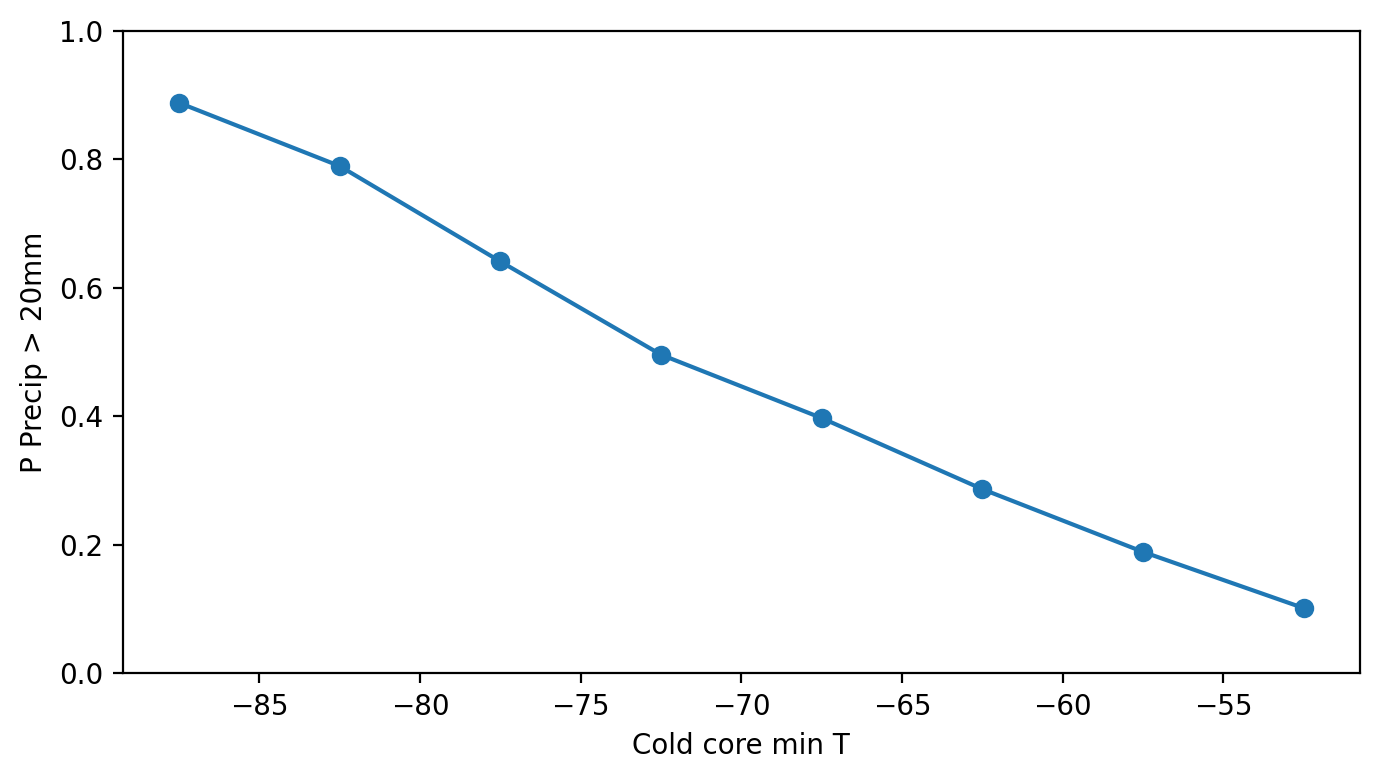

In [23]:
f= plt.figure(figsize=(7,4), dpi=200)

ax = f.add_subplot(111)
outdic = hist2d.var2_binning_threshold((test2['tmin']).values, (test2['precipitation_max']).values, np.arange(-90,-30,5), gt=10)
plt.plot(outdic['xbins'], outdic['y'], '-o')
ax.set_ylim(0,1)
plt.ylabel('P Precip > 20mm')
plt.xlabel('Cold core min T')
plt.tight_layout()
#f.savefig('/home/ck/Desktop/lmcs/20mm_precip_vs_CC_minT.jpg')

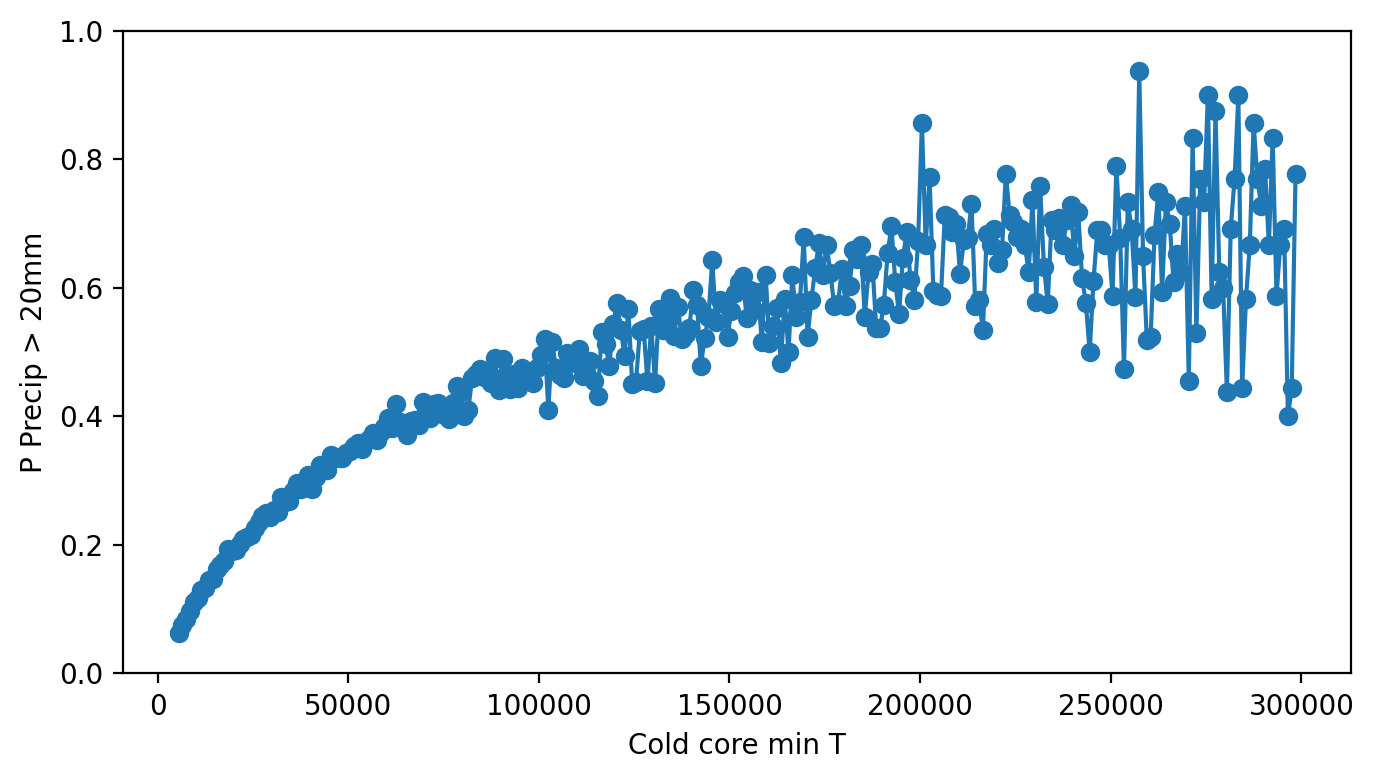

In [25]:
f= plt.figure(figsize=(7,4), dpi=200)

ax = f.add_subplot(111)
outdic = hist2d.var2_binning_threshold((test2['area']).values, (test2['precipitation_max']).values, np.arange(5000,300000,1000), gt=20)
plt.plot(outdic['xbins'], outdic['y'], '-o')
ax.set_ylim(0,1)
plt.ylabel('P Precip > 20mm')
plt.xlabel('Cold core min T')
plt.tight_layout()
#f.savefig('/home/ck/Desktop/lmcs/20mm_precip_vs_CC_minT.jpg')

In [28]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

PearsonRResult(statistic=0.22414325649327316, pvalue=0.0)


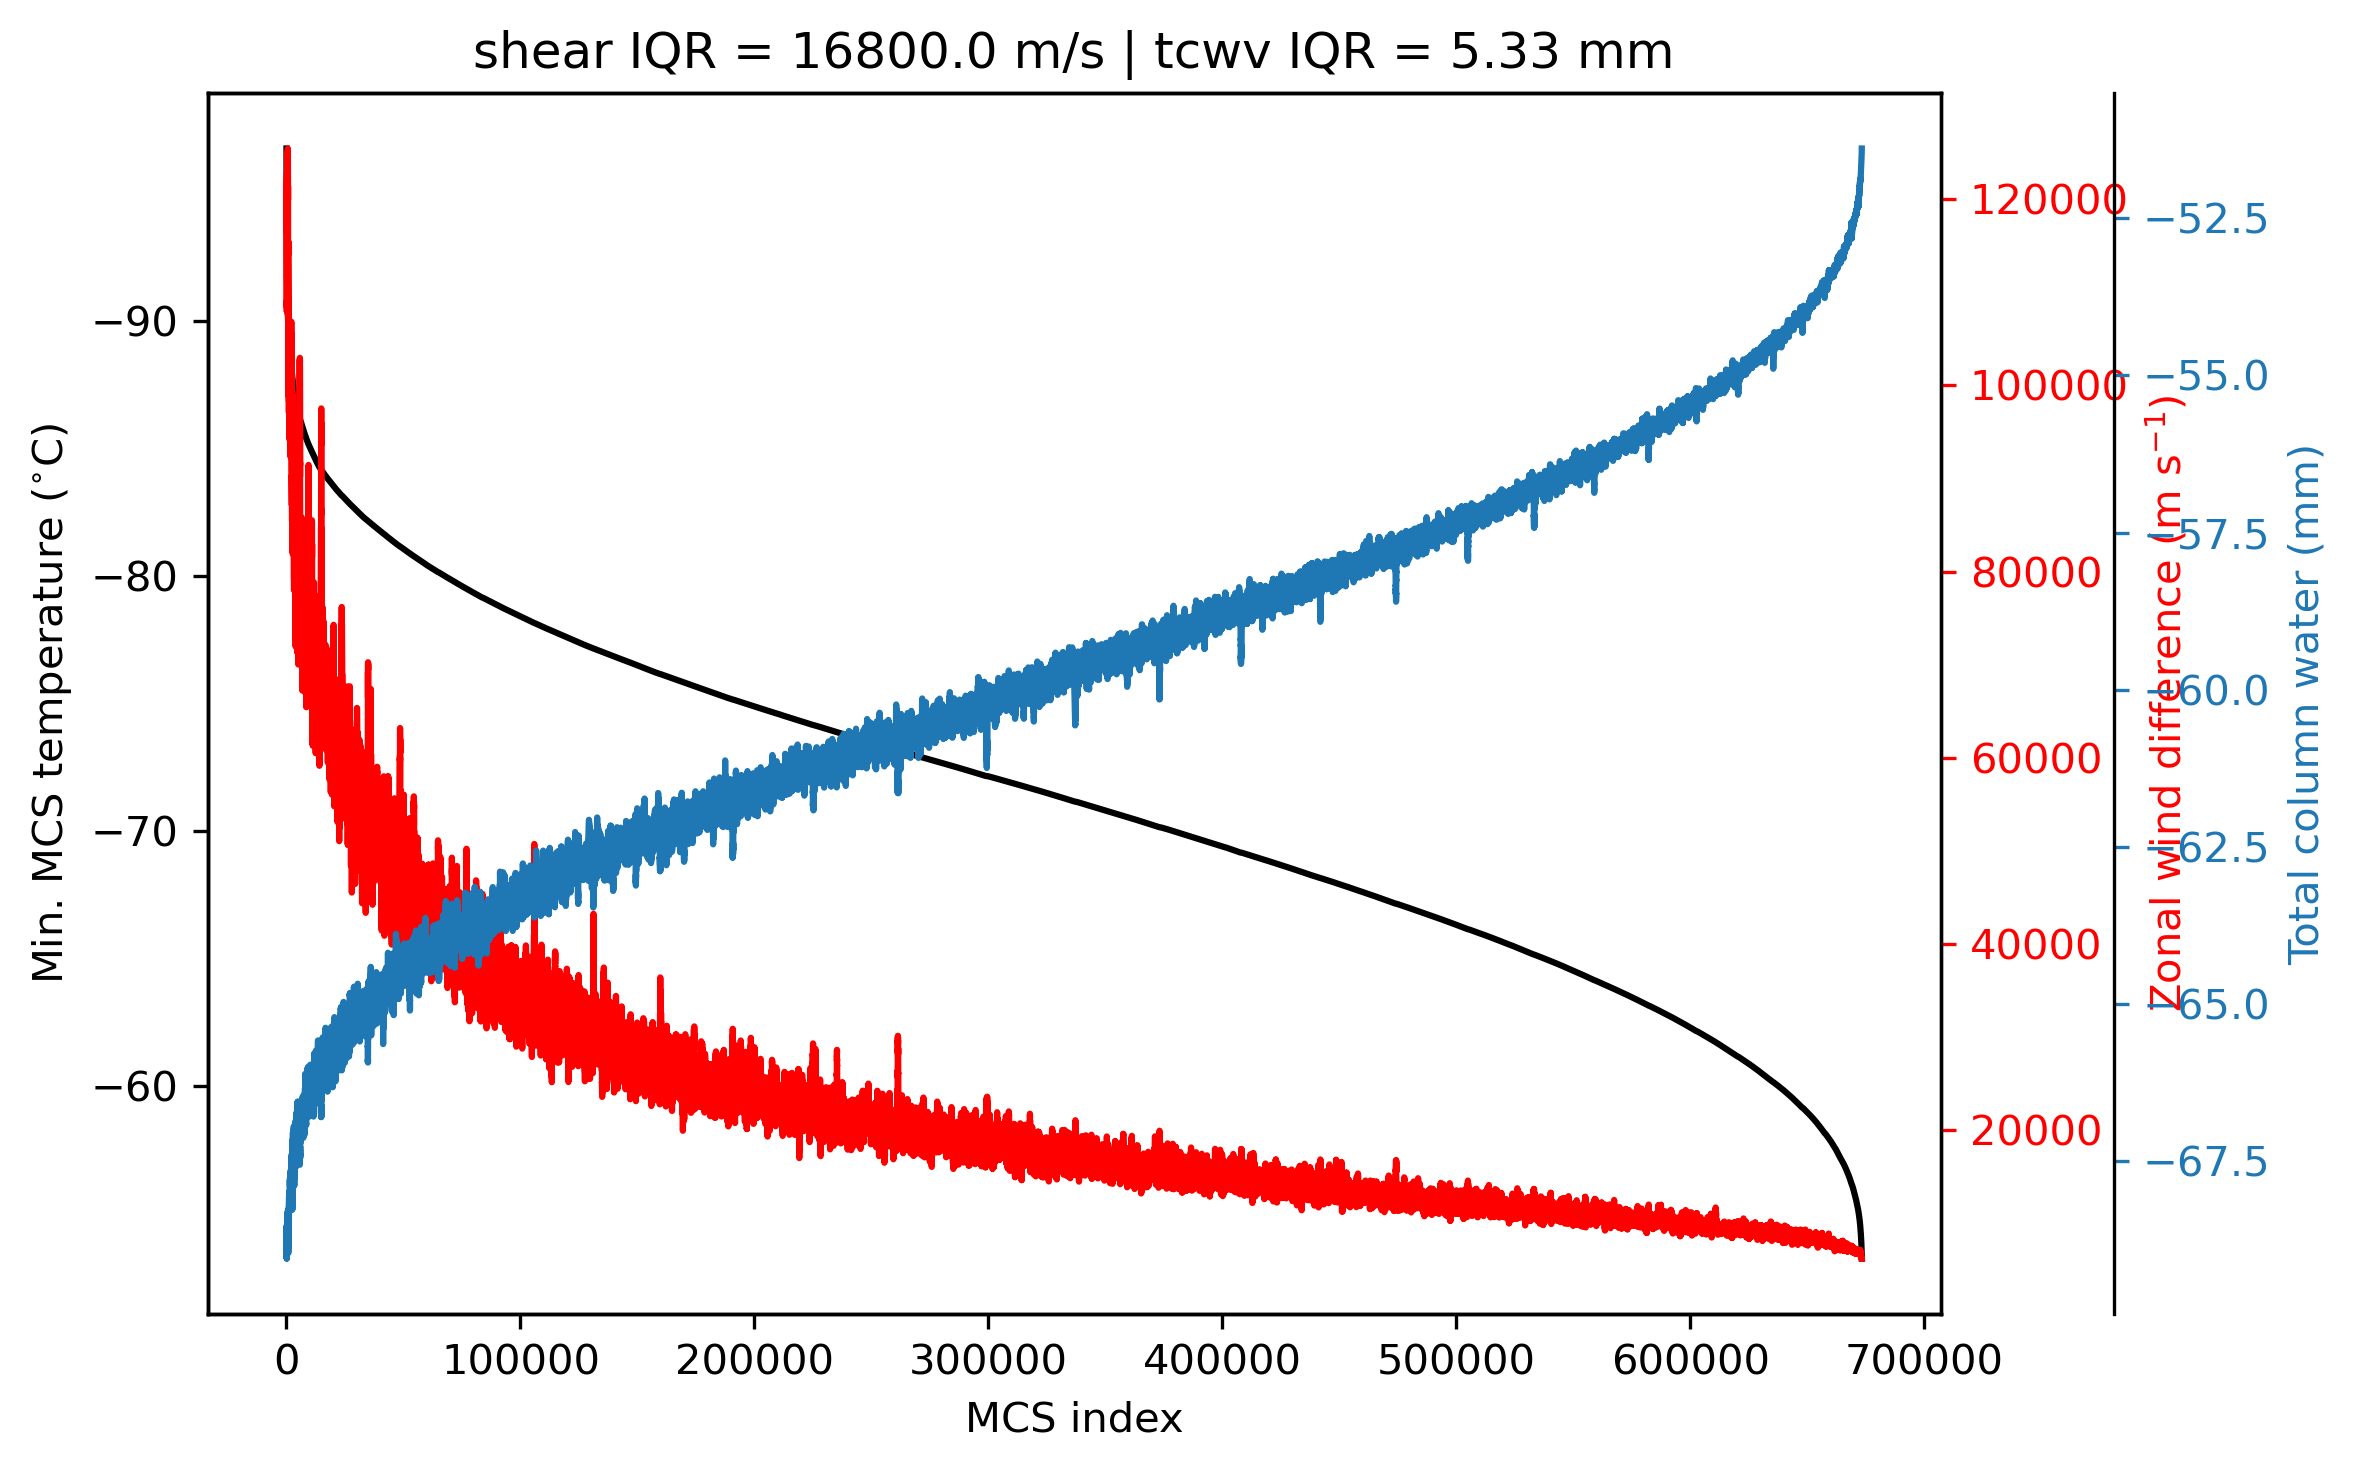

In [31]:
f= plt.figure(figsize=(8,5), dpi=300)

ax = f.add_subplot(111)

obs = test2

obsord = obs[np.isfinite(obs['tmin']) & np.isfinite(obs['precipitation_max'])] # & np.isfinite(obs['q925']) & np.isfinite(obs['t925'])
inds = np.argsort(obsord['tmin'])

minus = -20000
pro = obsord['tmin'].values[inds]#[minus::]
sho = obsord['area'].values[inds]#[minus::]
tco = obsord['tmean'].values[inds]#[minus::]
#    
ax2 = ax.twinx()
#ax3 = ax.twinx()
ax4 = ax.twinx()

agg = 200


# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
#ax2.spines["right"].set_position(("axes", 1.02))
#ax3.spines["right"].set_position(("axes", 1.1))
ax4.spines["right"].set_position(("axes", 1.1))

ax.plot(moving_average(pro,agg), label='pf1 area', color='k')
ax.invert_yaxis()

plt.title('shear IQR = '+str(np.round(np.nanpercentile(sho,75)-np.nanpercentile(sho,25),2))+' m/s' + ' | tcwv IQR = '+str(np.round(np.nanpercentile(tco,75)-np.nanpercentile(tco,25),2))+' mm')

p4, = ax4.plot(moving_average(tco,agg), label='tcwv')
p2, = ax2.plot(moving_average(sho,agg), label='ushear', color='r')
#     if ids in [2,3,4]: 
#         print(regs, 'doing minus 1')
#         ax2.invert_yaxis()
#p3, = ax3.plot(moving_average(qco,500), label='q925', color='purple')
#p4, = ax4.plot(moving_average(temp,500), label='t925', color='orange')

ax2.yaxis.label.set_color(p2.get_color())
#ax3.yaxis.label.set_color(p3.get_color())
ax4.yaxis.label.set_color(p4.get_color())

tw = moving_average(tco,agg)
twd = tw[1::]-tw[0:-1]
sw = moving_average(sho,agg)
swd = sw[1::]-sw[0:-1]

print(stats.pearsonr(twd,swd))

ax.set_ylabel('Min. MCS temperature ($^{\circ}$C)')
ax2.set_ylabel('Zonal wind difference (m s$^{-1}$)')
ax4.set_ylabel('Total column water (mm)')


ax2.tick_params(axis='y', colors=p2.get_color())
#ax3.tick_params(axis='y', colors=p3.get_color() )
ax4.tick_params(axis='y', colors=p4.get_color())


ax.set_xlabel('MCS index')


plt.tight_layout()


In [26]:
obs.keys()

Index(['direction', 'tminlon', 'tminlat', 'tmin_calc', 'tmin', 'tmean_core',
       'tmean_ccs', 'tcwv', 'tgrad2m', 'tgrad925',
       ...
       'init_lon', 'init_lat', 'utc_init_time', 'utc_init_hour',
       'lt_init_time', 'lt_init_hour', 'lt_time', 'lt_date', 'lt_hour',
       'lt_day'],
      dtype='object', length=154)

In [34]:
from utils import u_statistics as u_stats

15


Text(0.5, 1.0, 'MCS frequency (% per hour), UTC time')

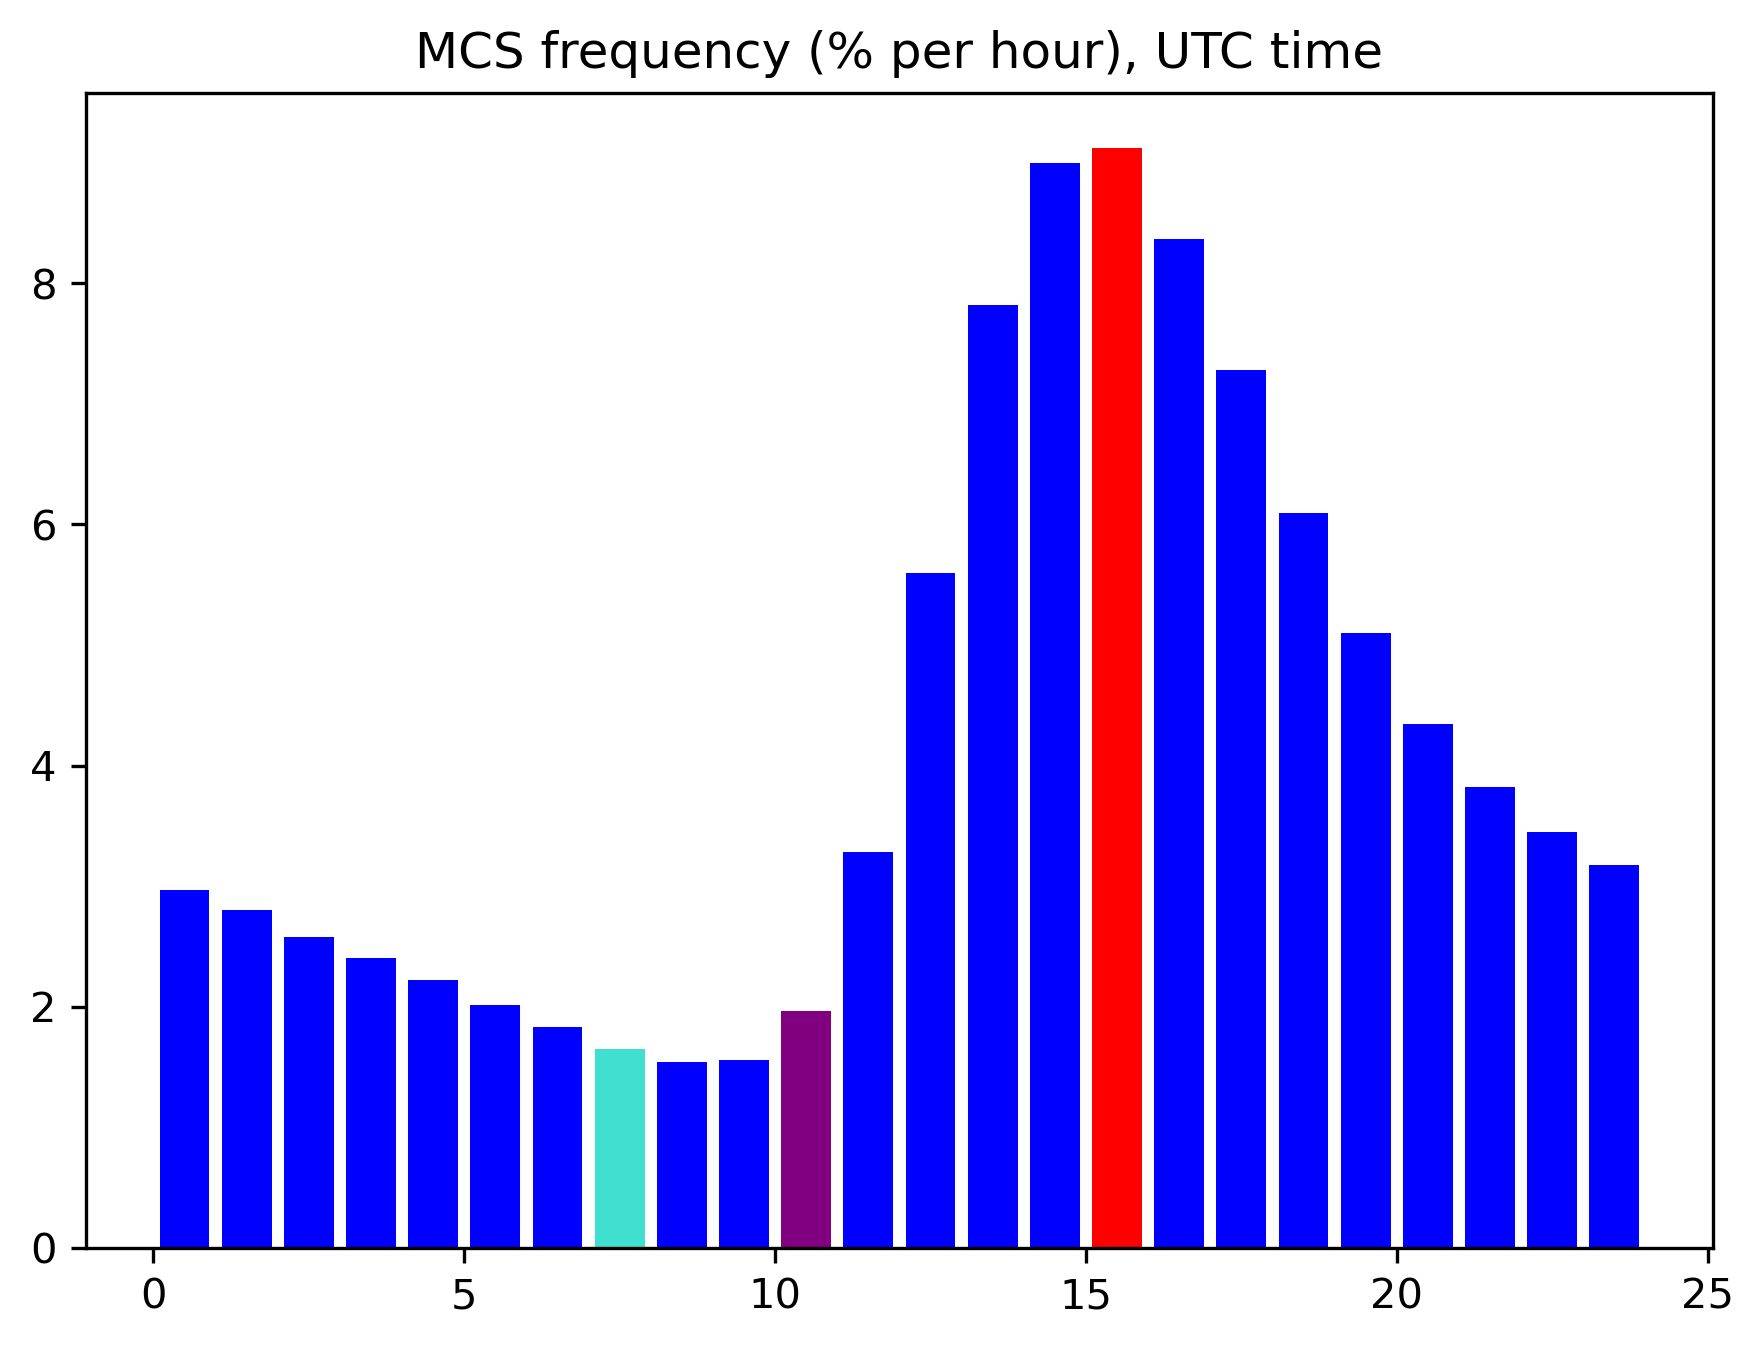

In [39]:
f= plt.figure(figsize=(7,5), dpi=300)

ax = f.add_subplot(111)

pick = test2
hist_freq, hist_count, bin_edge = u_stats.histo_frequency(pick['hour'], bins=np.arange(0,25))
#print(np.unique(pick['hour']))
mid_bin = bin_edge[0:-1] + (bin_edge[1::]-bin_edge[0:-1])/2
#m_bin = mid_bin - (MREGIONS[regs])[2]
#print(mid_bin)
colors = ['b']*24
ispos = int(np.where(mid_bin==18.5)[0])
secpos = int(np.where(mid_bin==13.5)[0])
firstpos = int(np.where(mid_bin==10.5)[0])
#minpos = ispos-(MREGIONS[regs])[2]
#ipdb.set_trace()
minpos = ispos-3
miinpos = firstpos - 3
miiinpos = secpos -3
print(minpos)
if minpos == 24:
    minpos=0

colors[minpos] = 'r'  # 1800
colors[miinpos] = 'turquoise' # 1100
colors[miiinpos] = 'purple' # 1400
ax.bar(mid_bin,hist_freq, align='center', color=colors)
plt.title('MCS frequency (% per hour), UTC time')


Text(0.5, 1.0, 'Minimum storm temperatures')

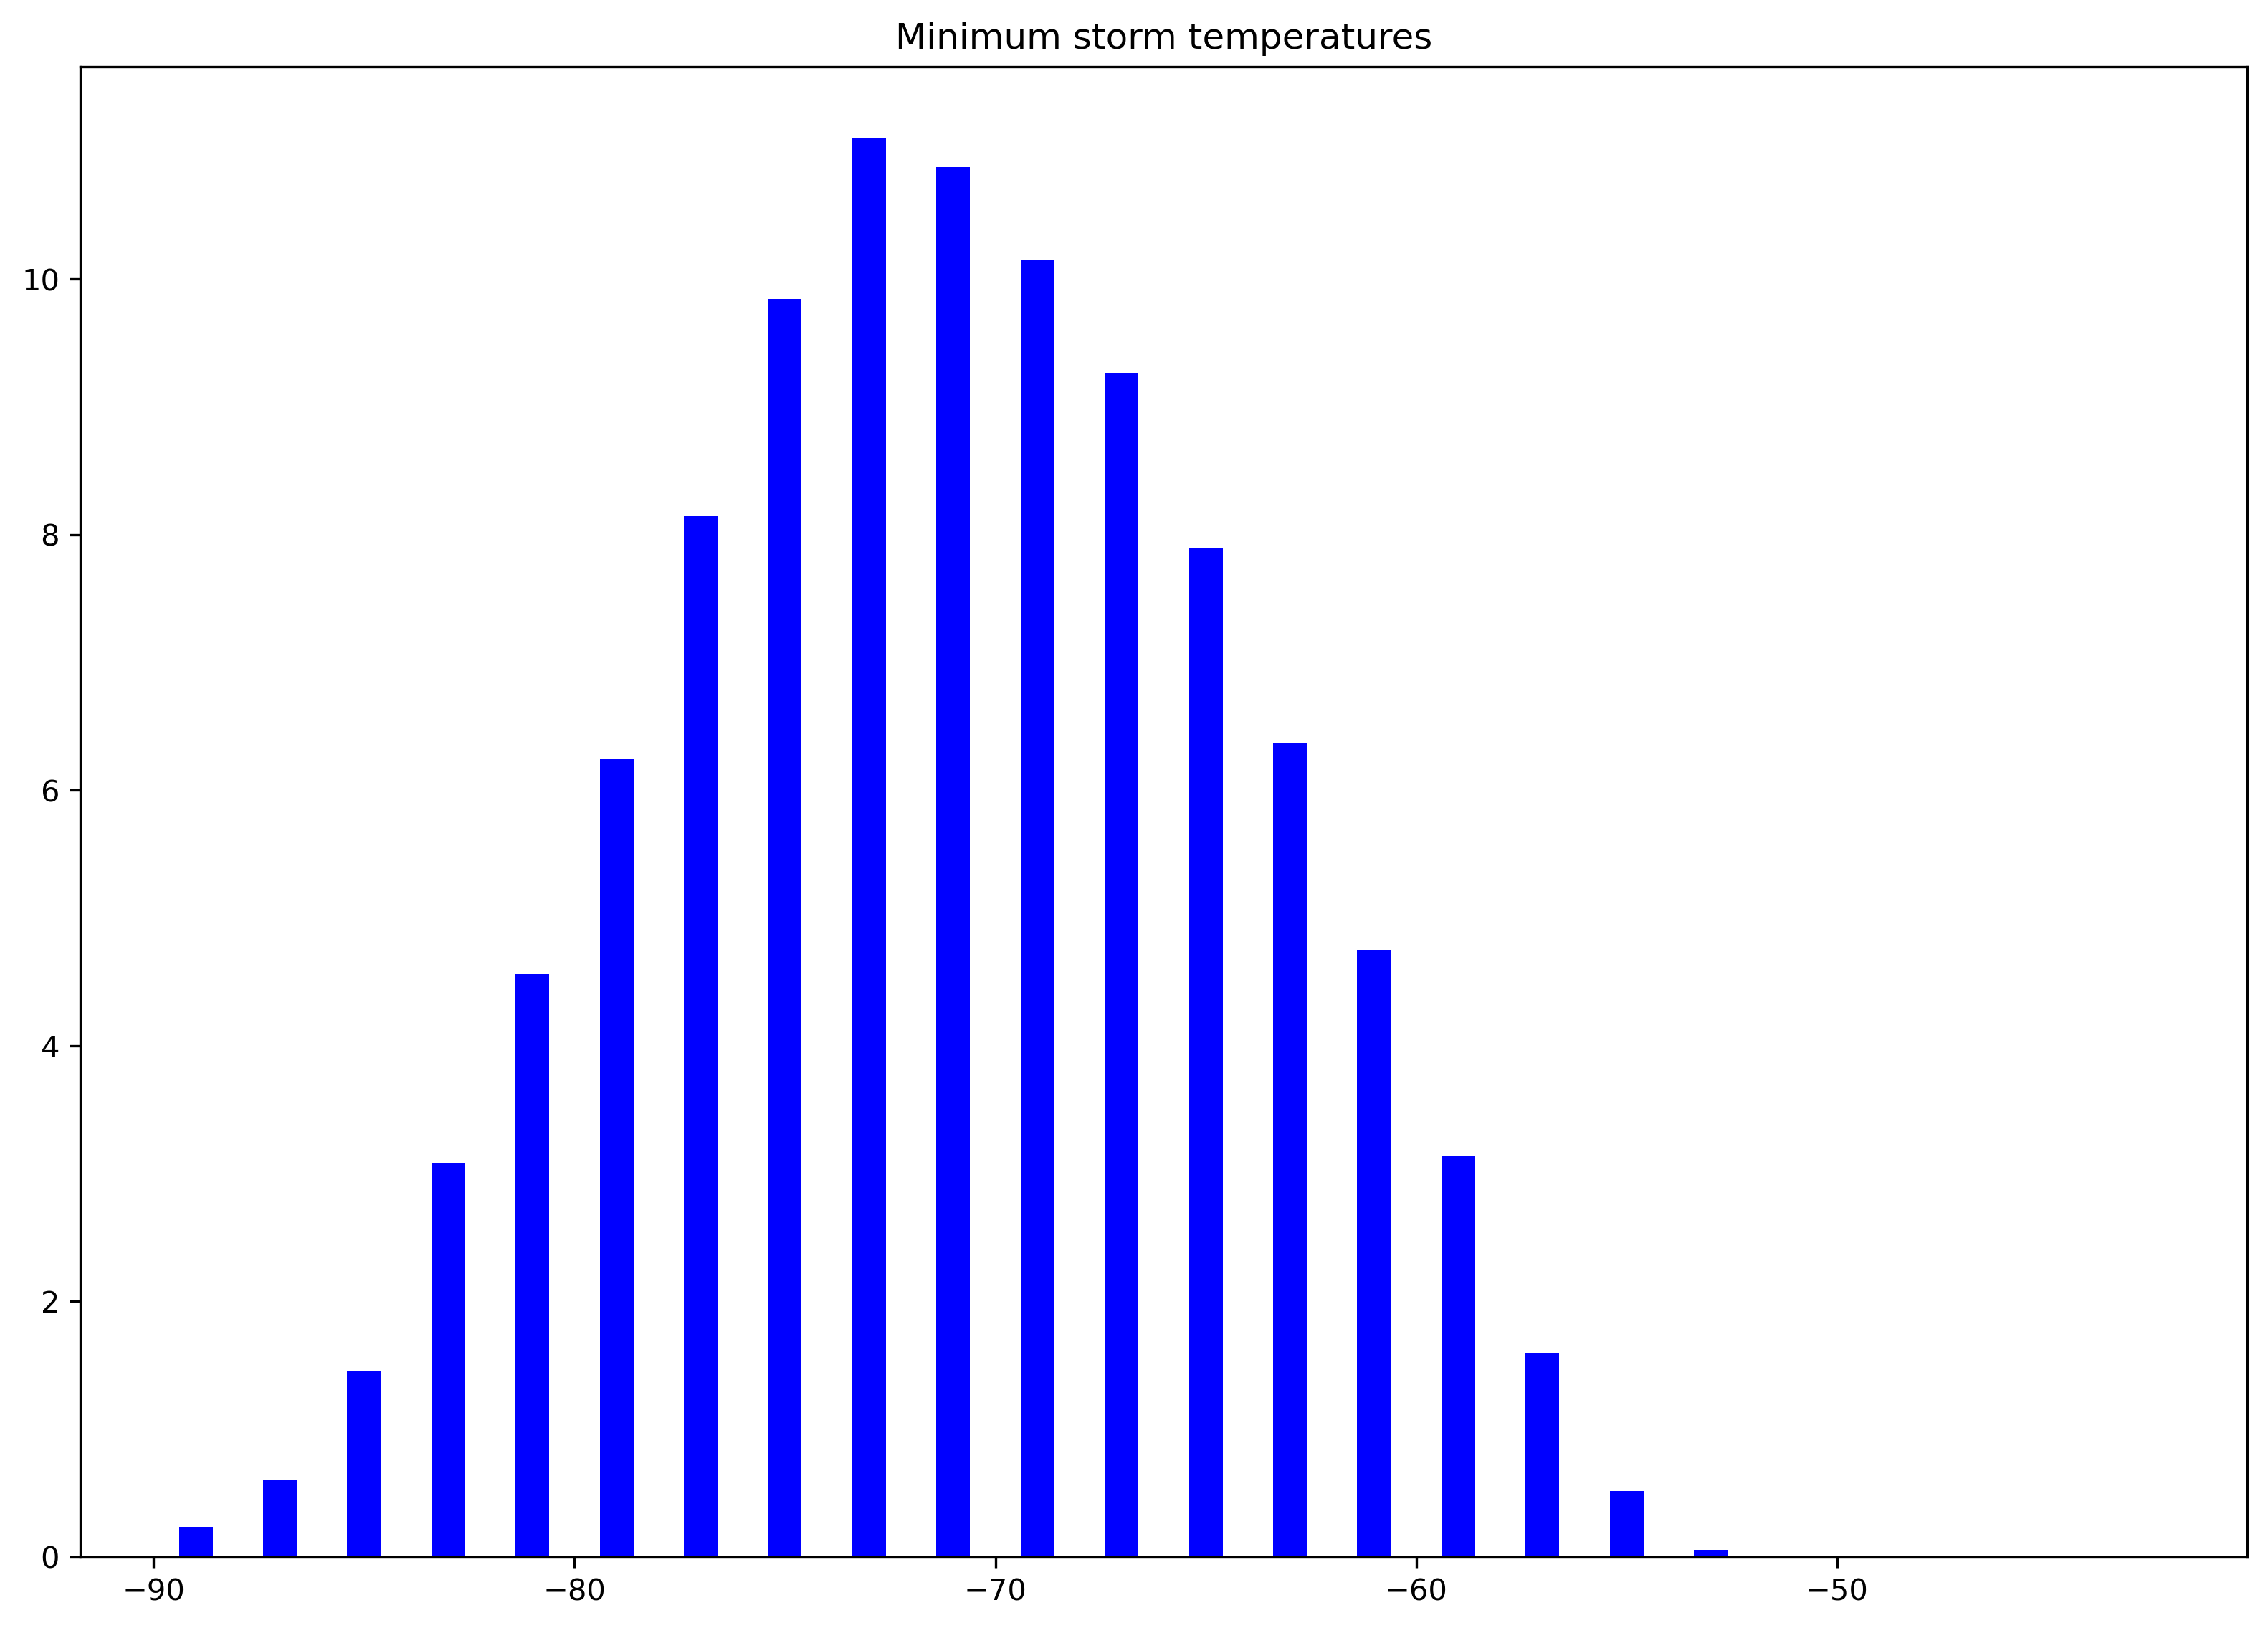

In [43]:
f= plt.figure(figsize=(13,9), dpi=300)
ax = f.add_subplot(111)

pick = test2

hist_freq, hist_count, bin_edge = u_stats.histo_frequency(pick['tmin'], bins=np.arange(-90,-40,2))
#print(np.unique(pick['hour']))
mid_bin = bin_edge[0:-1] + (bin_edge[1::]-bin_edge[0:-1])/2
#m_bin = mid_bin - (MREGIONS[regs])[2]
#print(mid_bin)
colors = ['b']*24
#     ispos = int(np.where(mid_bin==18.5)[0])
#     secpos = int(np.where(mid_bin==13.5)[0])
#     firstpos = int(np.where(mid_bin==10.5)[0])
#     #minpos = ispos-(MREGIONS[regs])[2]
#     #ipdb.set_trace()
#     minpos = ispos-(MREGIONS[regs])[2]
#     miinpos = firstpos - (MREGIONS[regs])[2]
#     miiinpos = secpos - (MREGIONS[regs])[2]
#     print(minpos)
#     if minpos == 24:
#         minpos=0

#     colors[minpos] = 'r'
#     colors[miinpos] = 'turquoise'
#     colors[miiinpos] = 'purple'
ax.bar(mid_bin,hist_freq, align='center', color=colors)
ax.set_title('Minimum storm temperatures')
#f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_mint_dist.jpg')

Text(0.5, 1.0, 'Minimum storm temperature')

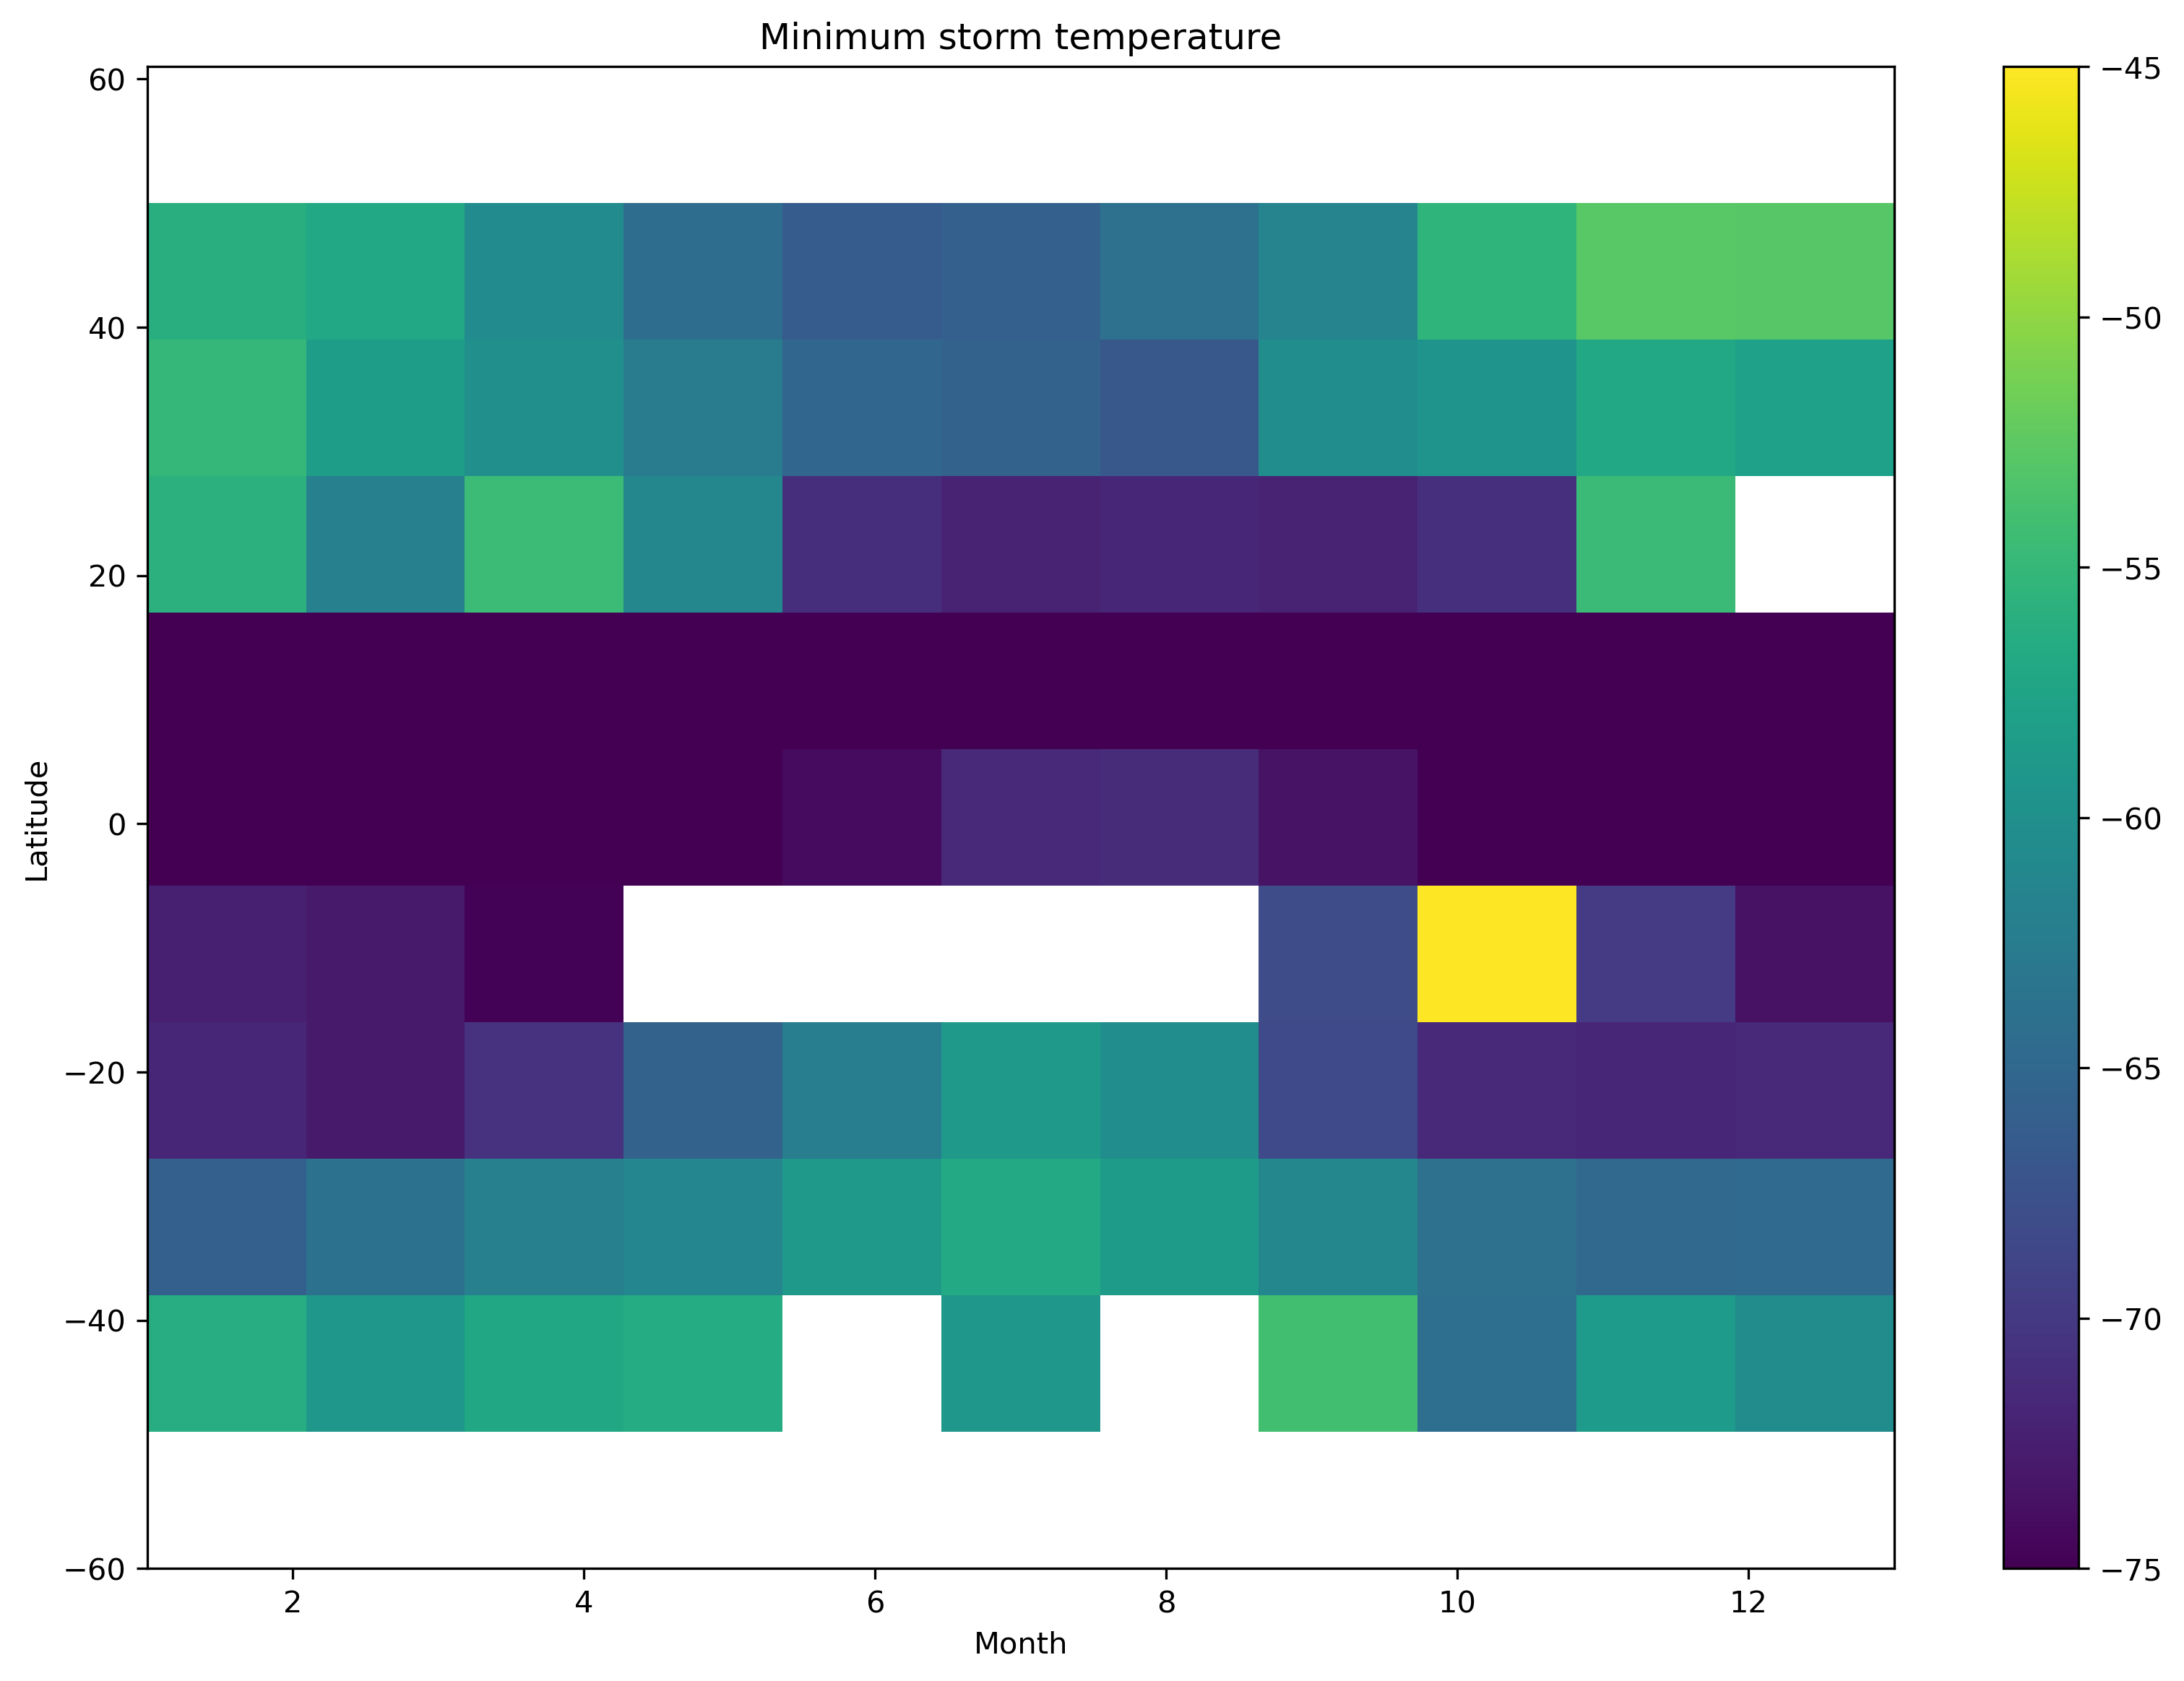

In [34]:
f= plt.figure(figsize=(13,9), dpi=300)
mon = []
lat = []
dat = []
for ids, regs in enumerate(MREGIONS.keys()):
    
    pick = rdics[regs]

    mon.extend(pick['utc_month'])
    lat.extend(pick['meanlat'])
    dat.extend(pick['corecold_mintb']-273.15)
    
    
tbin = np.linspace(-60,61,12)
sbin = np.linspace(1,13,12)

testbins = [sbin,tbin]
func1 = lambda y: np.mean(y) #np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
func2 = lambda y: np.sum(np.isfinite(y))
func3 = lambda y: np.sum(y>1)

ax = f.add_subplot(111)

ret = binned_statistic_2d(mon, lat, dat, statistic=func1, bins=testbins)
# count = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func2, bins=testbins)
# thresh = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func3, bins=testbins)

dd=ret.statistic.T

mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap='viridis', vmin=-75, vmax=-45) #vmax=p2-1, vmin=0.5  ##p2-1
plt.colorbar(mp)
plt.ylabel('Latitude')
plt.xlabel('Month')
plt.title('Minimum storm temperature')

# colours = ['r', 'k', 'b', 'y', 'g', 'w', 'r']
# for ids, regs in enumerate(MREGIONS.keys()):
    
#     pick = rdics[regs]
#     plt.scatter(pick['month'],pick['meanlat'], marker='x', s=1, color=colours[ids], label=regs)
# plt.legend(loc='upper left')
#f.savefig('/home/ck/Desktop/lmcs/latitude_mean_minT_heatmap_mixed.jpg')

Text(0.5, 0, 'Year')

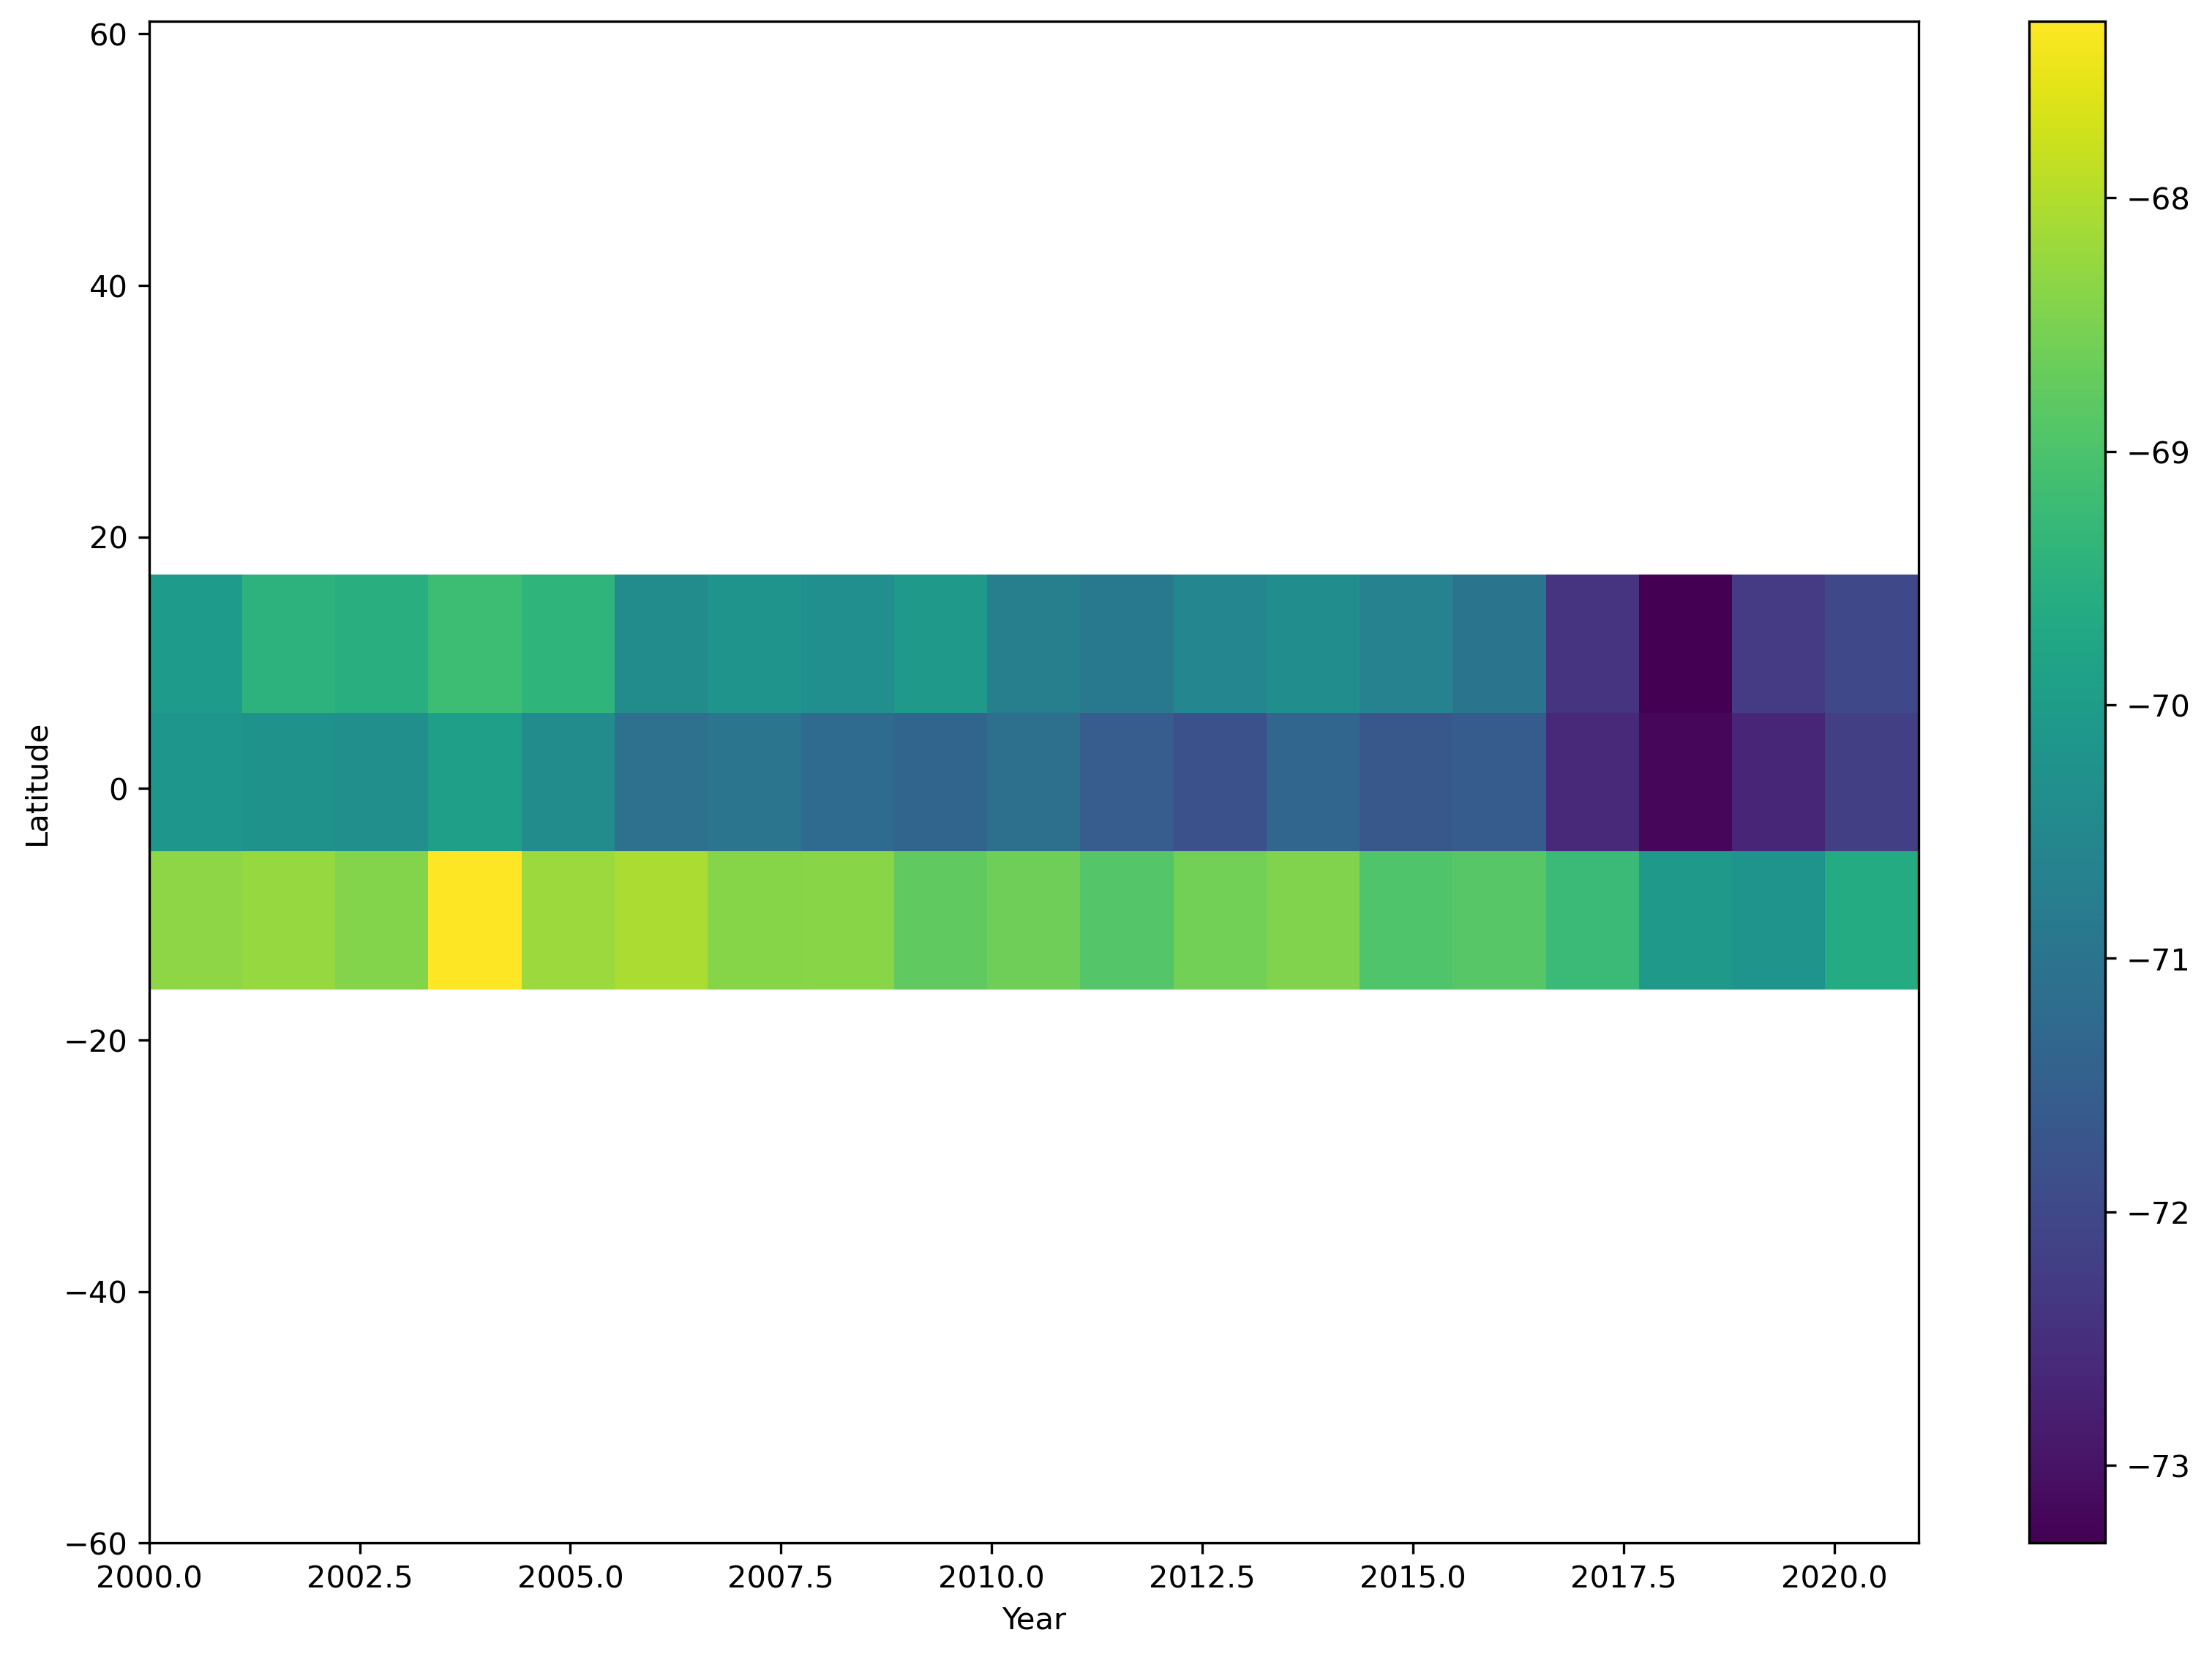

In [48]:
f= plt.figure(figsize=(13,9), dpi=300)
mon = []
lat = []
dat = []


pick = test2
mon.extend(pick['year'])
lat.extend(pick['clat'])
dat.extend(pick['tmin'])


tbin = np.linspace(-60,61,12)
sbin = np.linspace(2000,2021,20)

testbins = [sbin,tbin]
func1 = lambda y: np.mean(y) #np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
func2 = lambda y: np.sum(np.isfinite(y))
func3 = lambda y: np.sum(y>1)

ax = f.add_subplot(111)

ret = binned_statistic_2d(mon, lat, dat, statistic=func1, bins=testbins)
# count = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func2, bins=testbins)
# thresh = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func3, bins=testbins)

dd=ret.statistic.T

mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap='viridis') #vmax=p2-1, vmin=0.5  ##p2-1
plt.colorbar(mp)
plt.ylabel('Latitude')
plt.xlabel('Year')

# colours = ['r', 'k', 'b', 'y', 'g', 'w', 'r']
# for ids, regs in enumerate(MREGIONS.keys()):

#     pick = rdics[regs]
#     plt.scatter(pick['month'],pick['meanlat'], marker='x', s=1, color=colours[ids], label=regs)
# plt.legend(loc='upper left')
#f.savefig('/home/ck/Desktop/lmcs/latitude_mean_minT_heatmap_ccsArea.jpg')

/tmp/ipykernel_4049/4122171313.py:17: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  func1 = lambda y: np.percentile(y,99, interpolation='nearest') #np.percentile(y, 95)
/tmp/ipykernel_4049/4122171313.py:17: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  func1 = lambda y: np.percentile(y,99, interpolation='nearest') #np.percentile(y, 95)


Text(0.5, 0, 'Year')

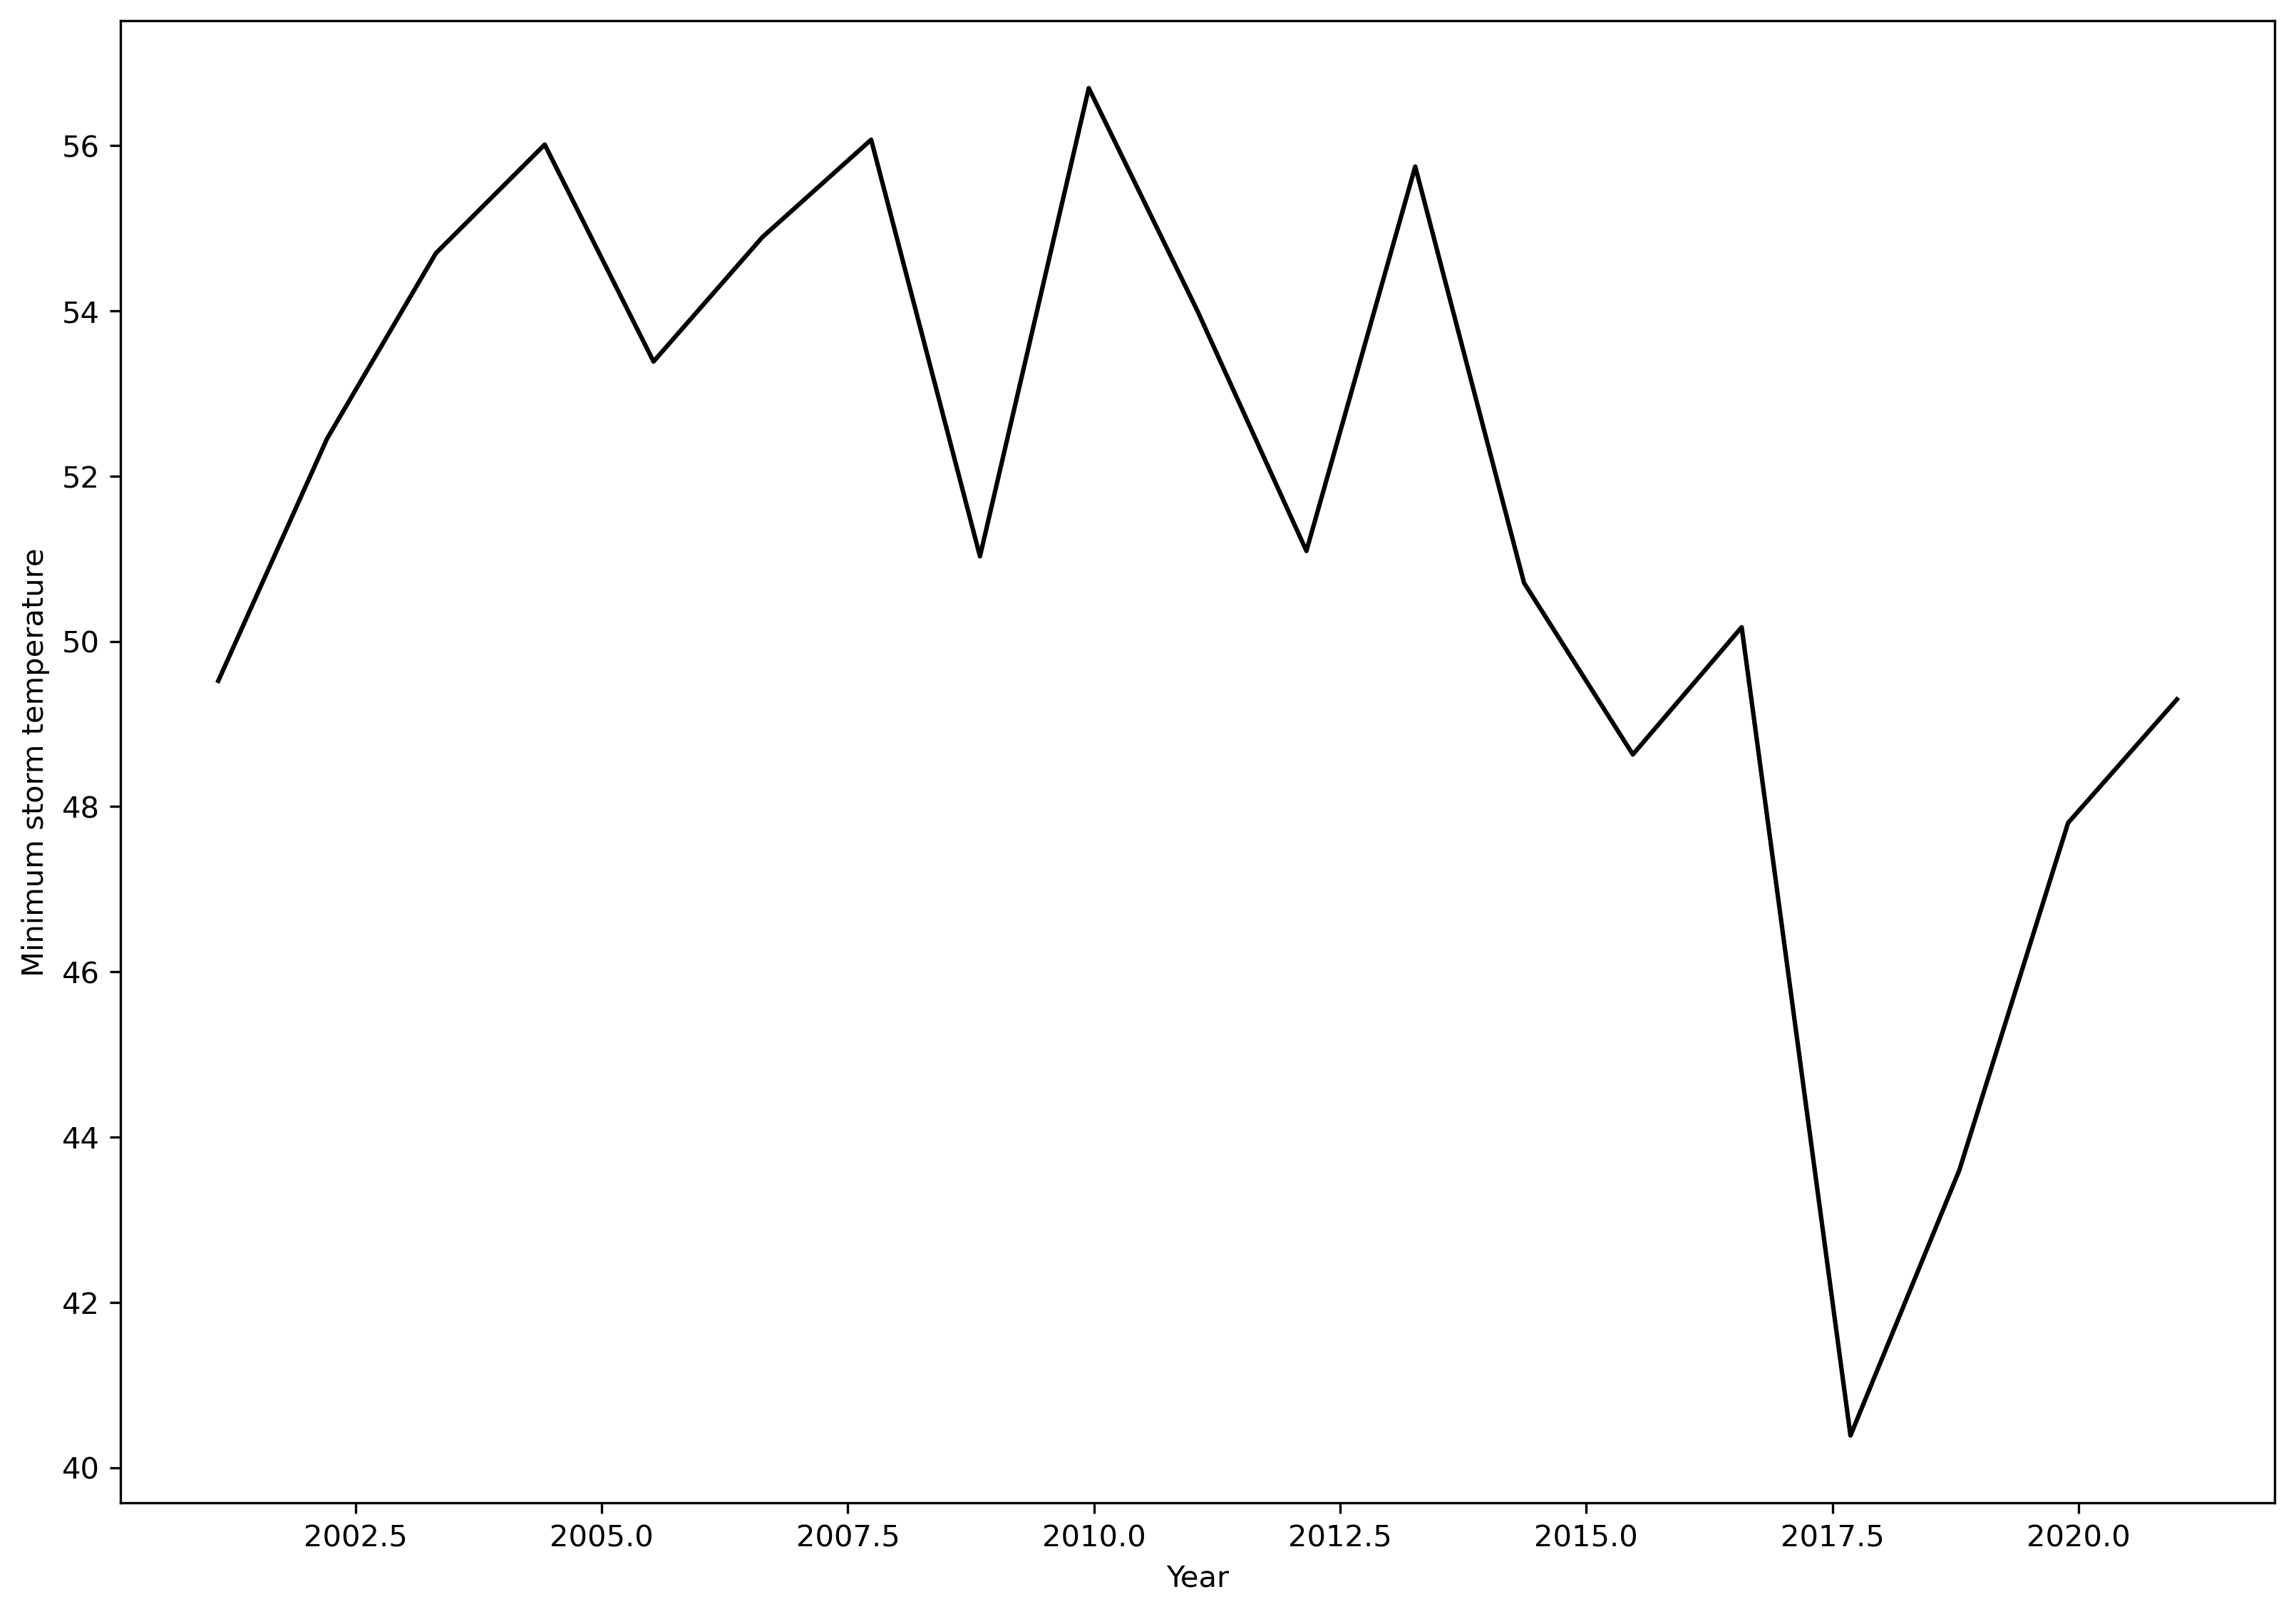

In [67]:
f= plt.figure(figsize=(13,9), dpi=300)
mon = []
lat = []
dat = []


pick = test2
mon.extend(pick['year'])
lat.extend(pick['clat'])
dat.extend(pick['precipitation_max'])


tbin = np.linspace(-60,61,12)
sbin = np.linspace(2000,2021,20)

testbins = [sbin,tbin]
func1 = lambda y: np.percentile(y,99, interpolation='nearest') #np.percentile(y, 95)
func2 = lambda y: np.sum(np.isfinite(y))
func3 = lambda y: np.sum(y>1)
func4 = lambda y: y.size

ax = f.add_subplot(111)

ret = binned_statistic(mon, dat, statistic=func1, bins=sbin)
# count = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func2, bins=testbins)
# thresh = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func3, bins=testbins)

dd=ret.statistic

cbin = sbin[0:-1] + (sbin[1::]-sbin[0:-1])

mp = plt.plot(cbin, dd, color='k') #vmax=p2-1, vmin=0.5  ##p2-1
plt.ylabel('Minimum storm temperature')
plt.xlabel('Year')

# colours = ['r', 'k', 'b', 'y', 'g', 'w', 'r']
# for ids, regs in enumerate(MREGIONS.keys()):

#     pick = rdics[regs]
#     plt.scatter(pick['month'],pick['meanlat'], marker='x', s=1, color=colours[ids], label=regs)
# plt.legend(loc='upper left')
#f.savefig('/home/ck/Desktop/lmcs/latitude_mean_minT_heatmap_ccsArea.jpg')

<Axes: ylabel='Frequency'>

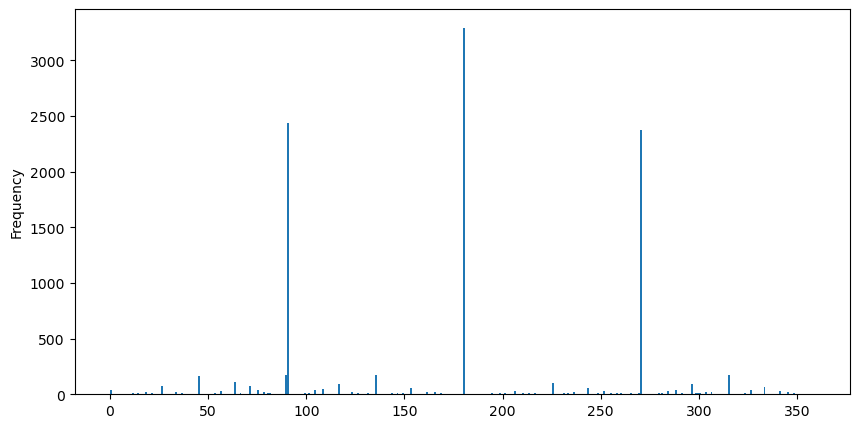

In [24]:
(rdics['india'])['direction'].plot.hist(bins=np.arange(0,360,1))

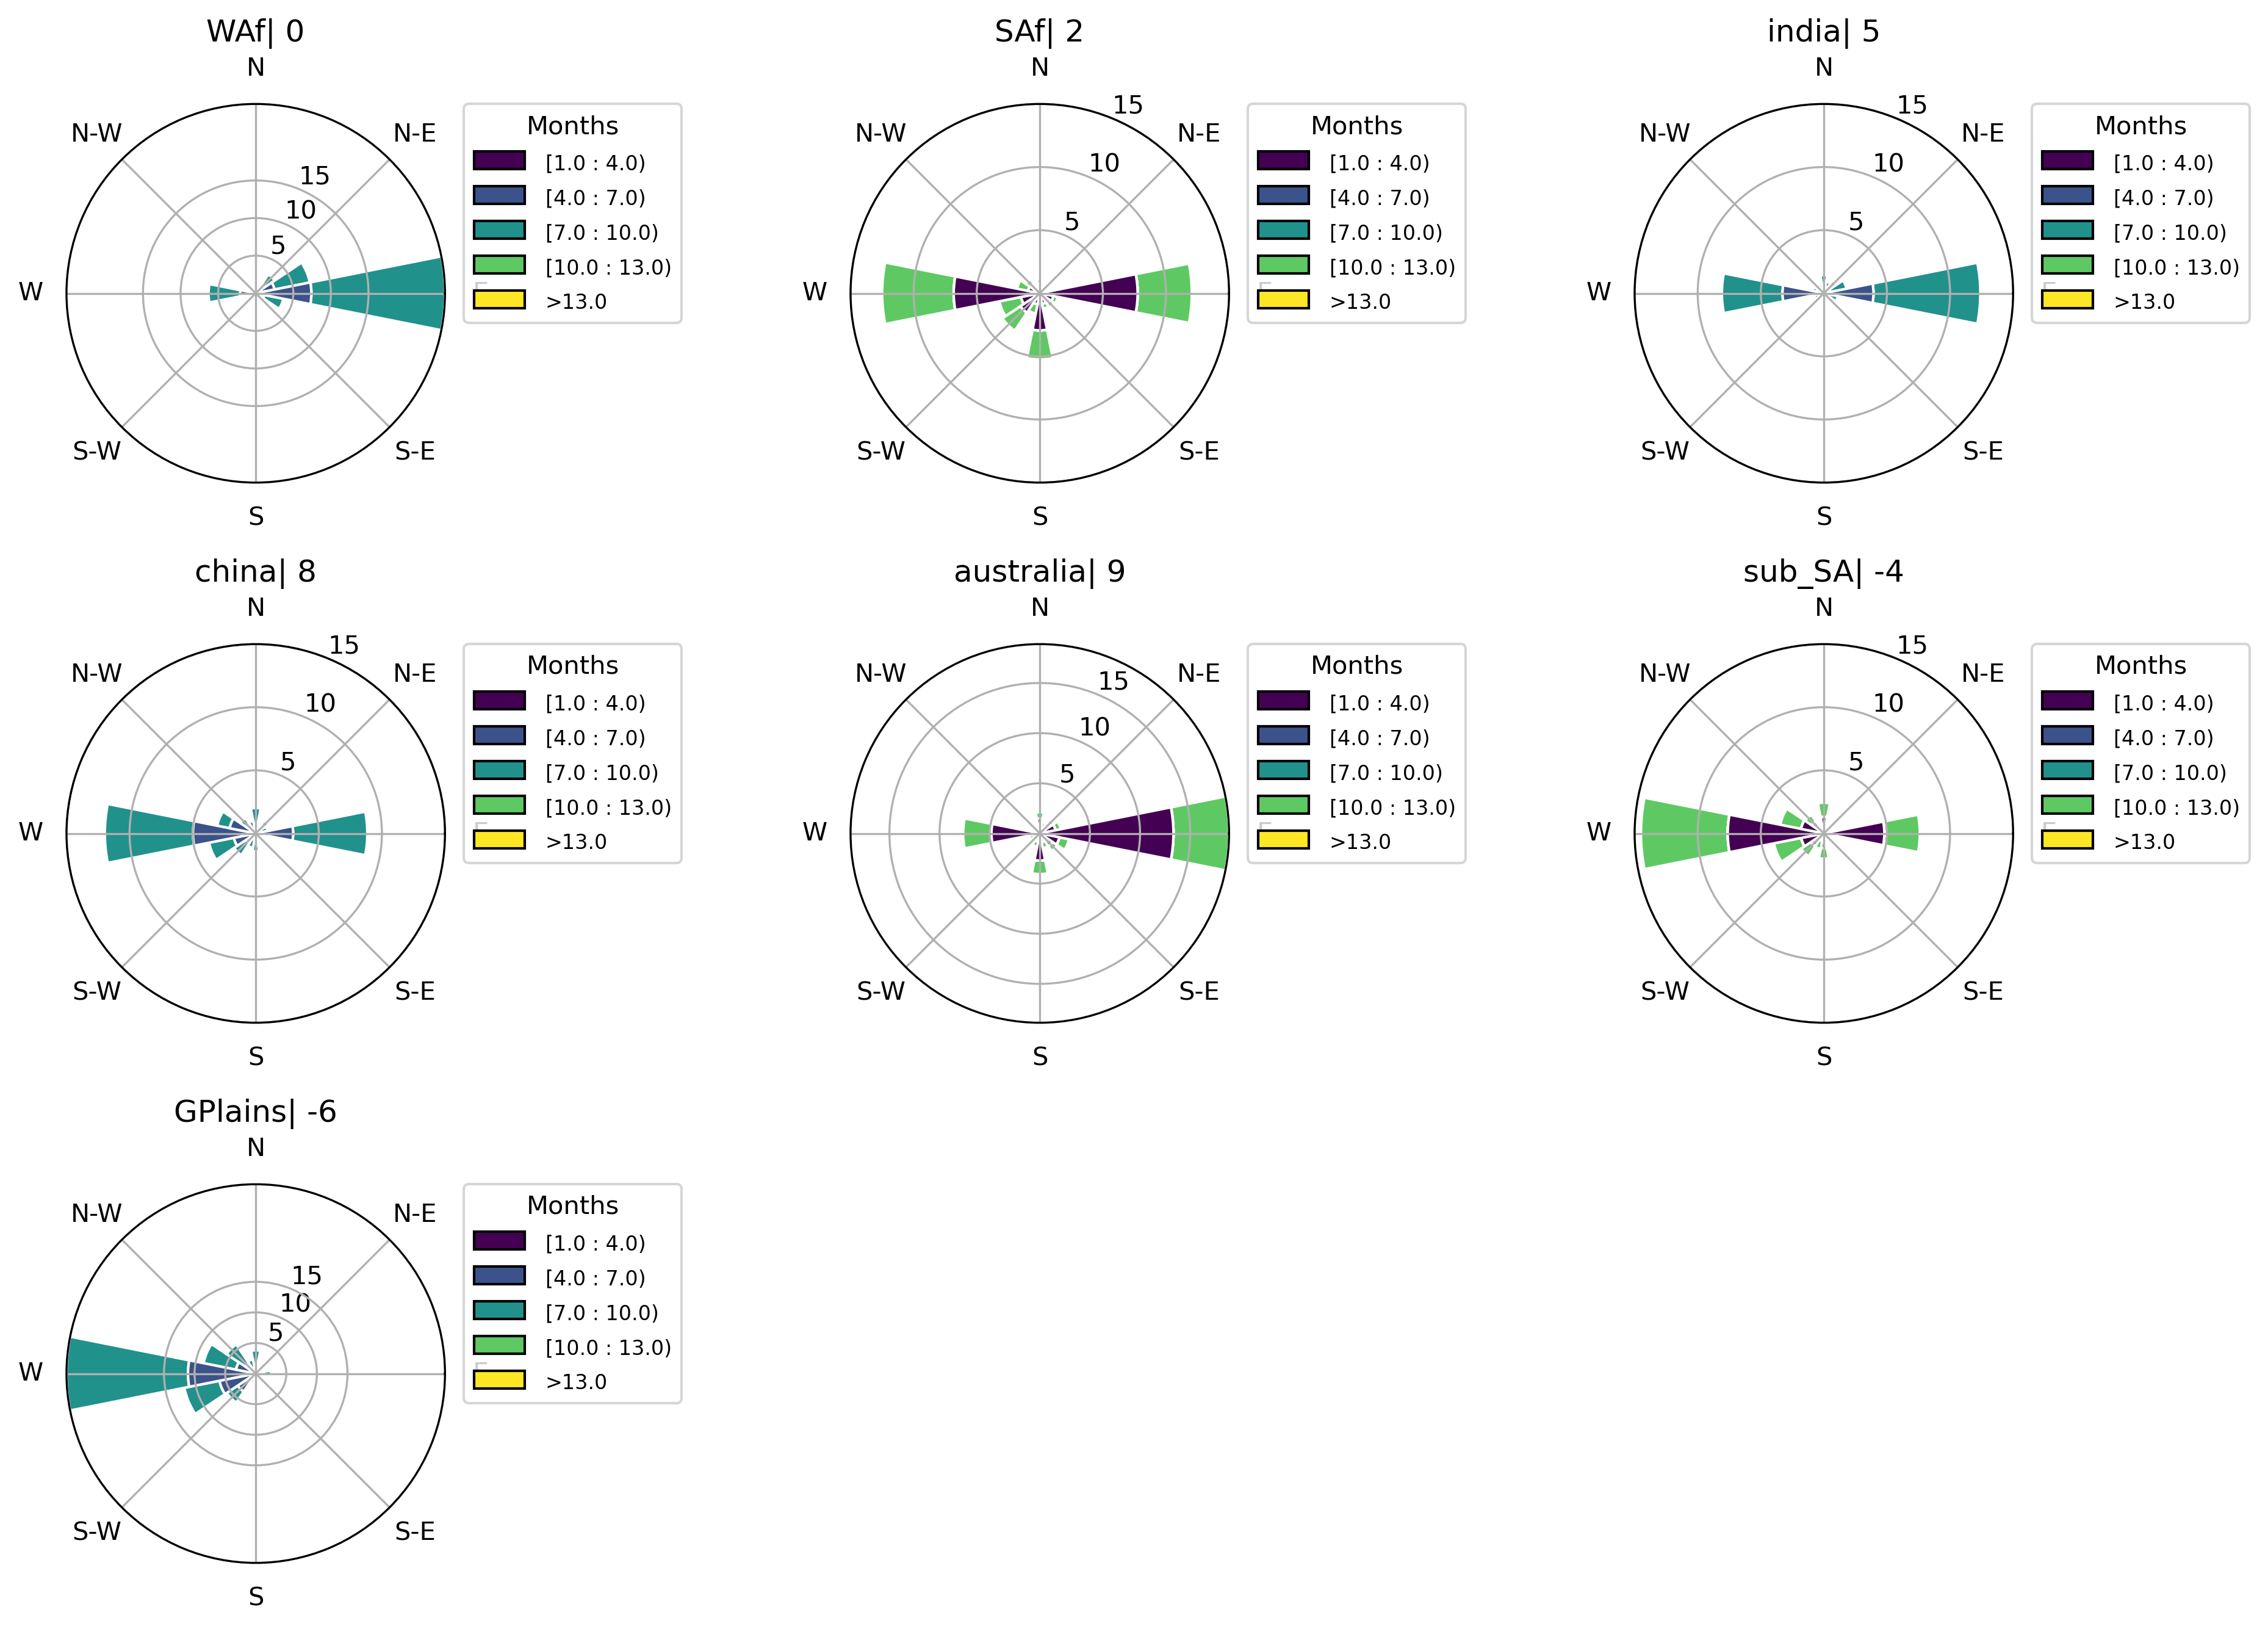

In [73]:
MREGIONS = {'WAf' : [[-18,25,4,25], 'spac', 0, (1,7), (5,9), (1,12)], # last is hourly offset to UCT # 12    # [-18,25,4,25]
 'SAf' : [[20,35, -35,-15], 'spac', 2, (9,12), (11,3), (11,3)], # 10
 'india' : [[70,90, 5,30], 'asia', 5, (1,7), (5,9), (1,12)], # 7
 'china' : [[105,115,25,40], 'asia', 8 , (1,7), (5,9), (1,12)], # 4
 'australia' : [[120,140,-23, -11], 'asia', 9, (11,3), (1,5), (1,12)], # 3
 'sub_SA' : [[-68,-47, -40, -20.5], 'spac', -4, (11,3), (1,5), (1,12)] , # 16
# 'trop_SA' : [[-75, -50, -20, -5], 'spac', -5, (1,12), (1,12), (1,12)], # 17
 'GPlains' : [[-100,-90,32,47], 'nam', -6, (1,7), (5,9), (1,12)] # # 18

}

f= plt.figure(figsize=(13,9), dpi=300)
maxval = [45,30,25,40,30,35,40]

for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1,  projection='windrose')
    
    pick = (rdics[regs])
    #pick = pick[(pick['utc_month']>=11) | (pick['utc_month']<=2)]

    umean = (pick['movement_distance_x'])
    vmean = (pick['movement_distance_y'])
    
    ws, avg_wd = u_met.u_v_to_ws_wd(umean,vmean)
    
    direct = avg_wd
    
    #####################
    ws_array2 = pick['utc_month']  #np.array(wsin.flatten())
    wd_array2 = direct

    ax = WindroseAxes.from_ax(ax)
    ax.bar(wd_array2, ws_array2, normed=True, opening=1.0, edgecolor='white', bins=[1,4,7,10,13])  #, colors=color_s[0:5]
    ax.set_yticks(np.arange(5, 20, step=5))
    ax.set_yticklabels(np.arange(5, 20, step=5))



    ax.set_title(regs + '| '+str((MREGIONS[regs])[2]))
    ax.set_legend(title = 'Months', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_mint_dist.jpg')

plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/LMCS/storm_direction_windrose_datasetV2.jpg')

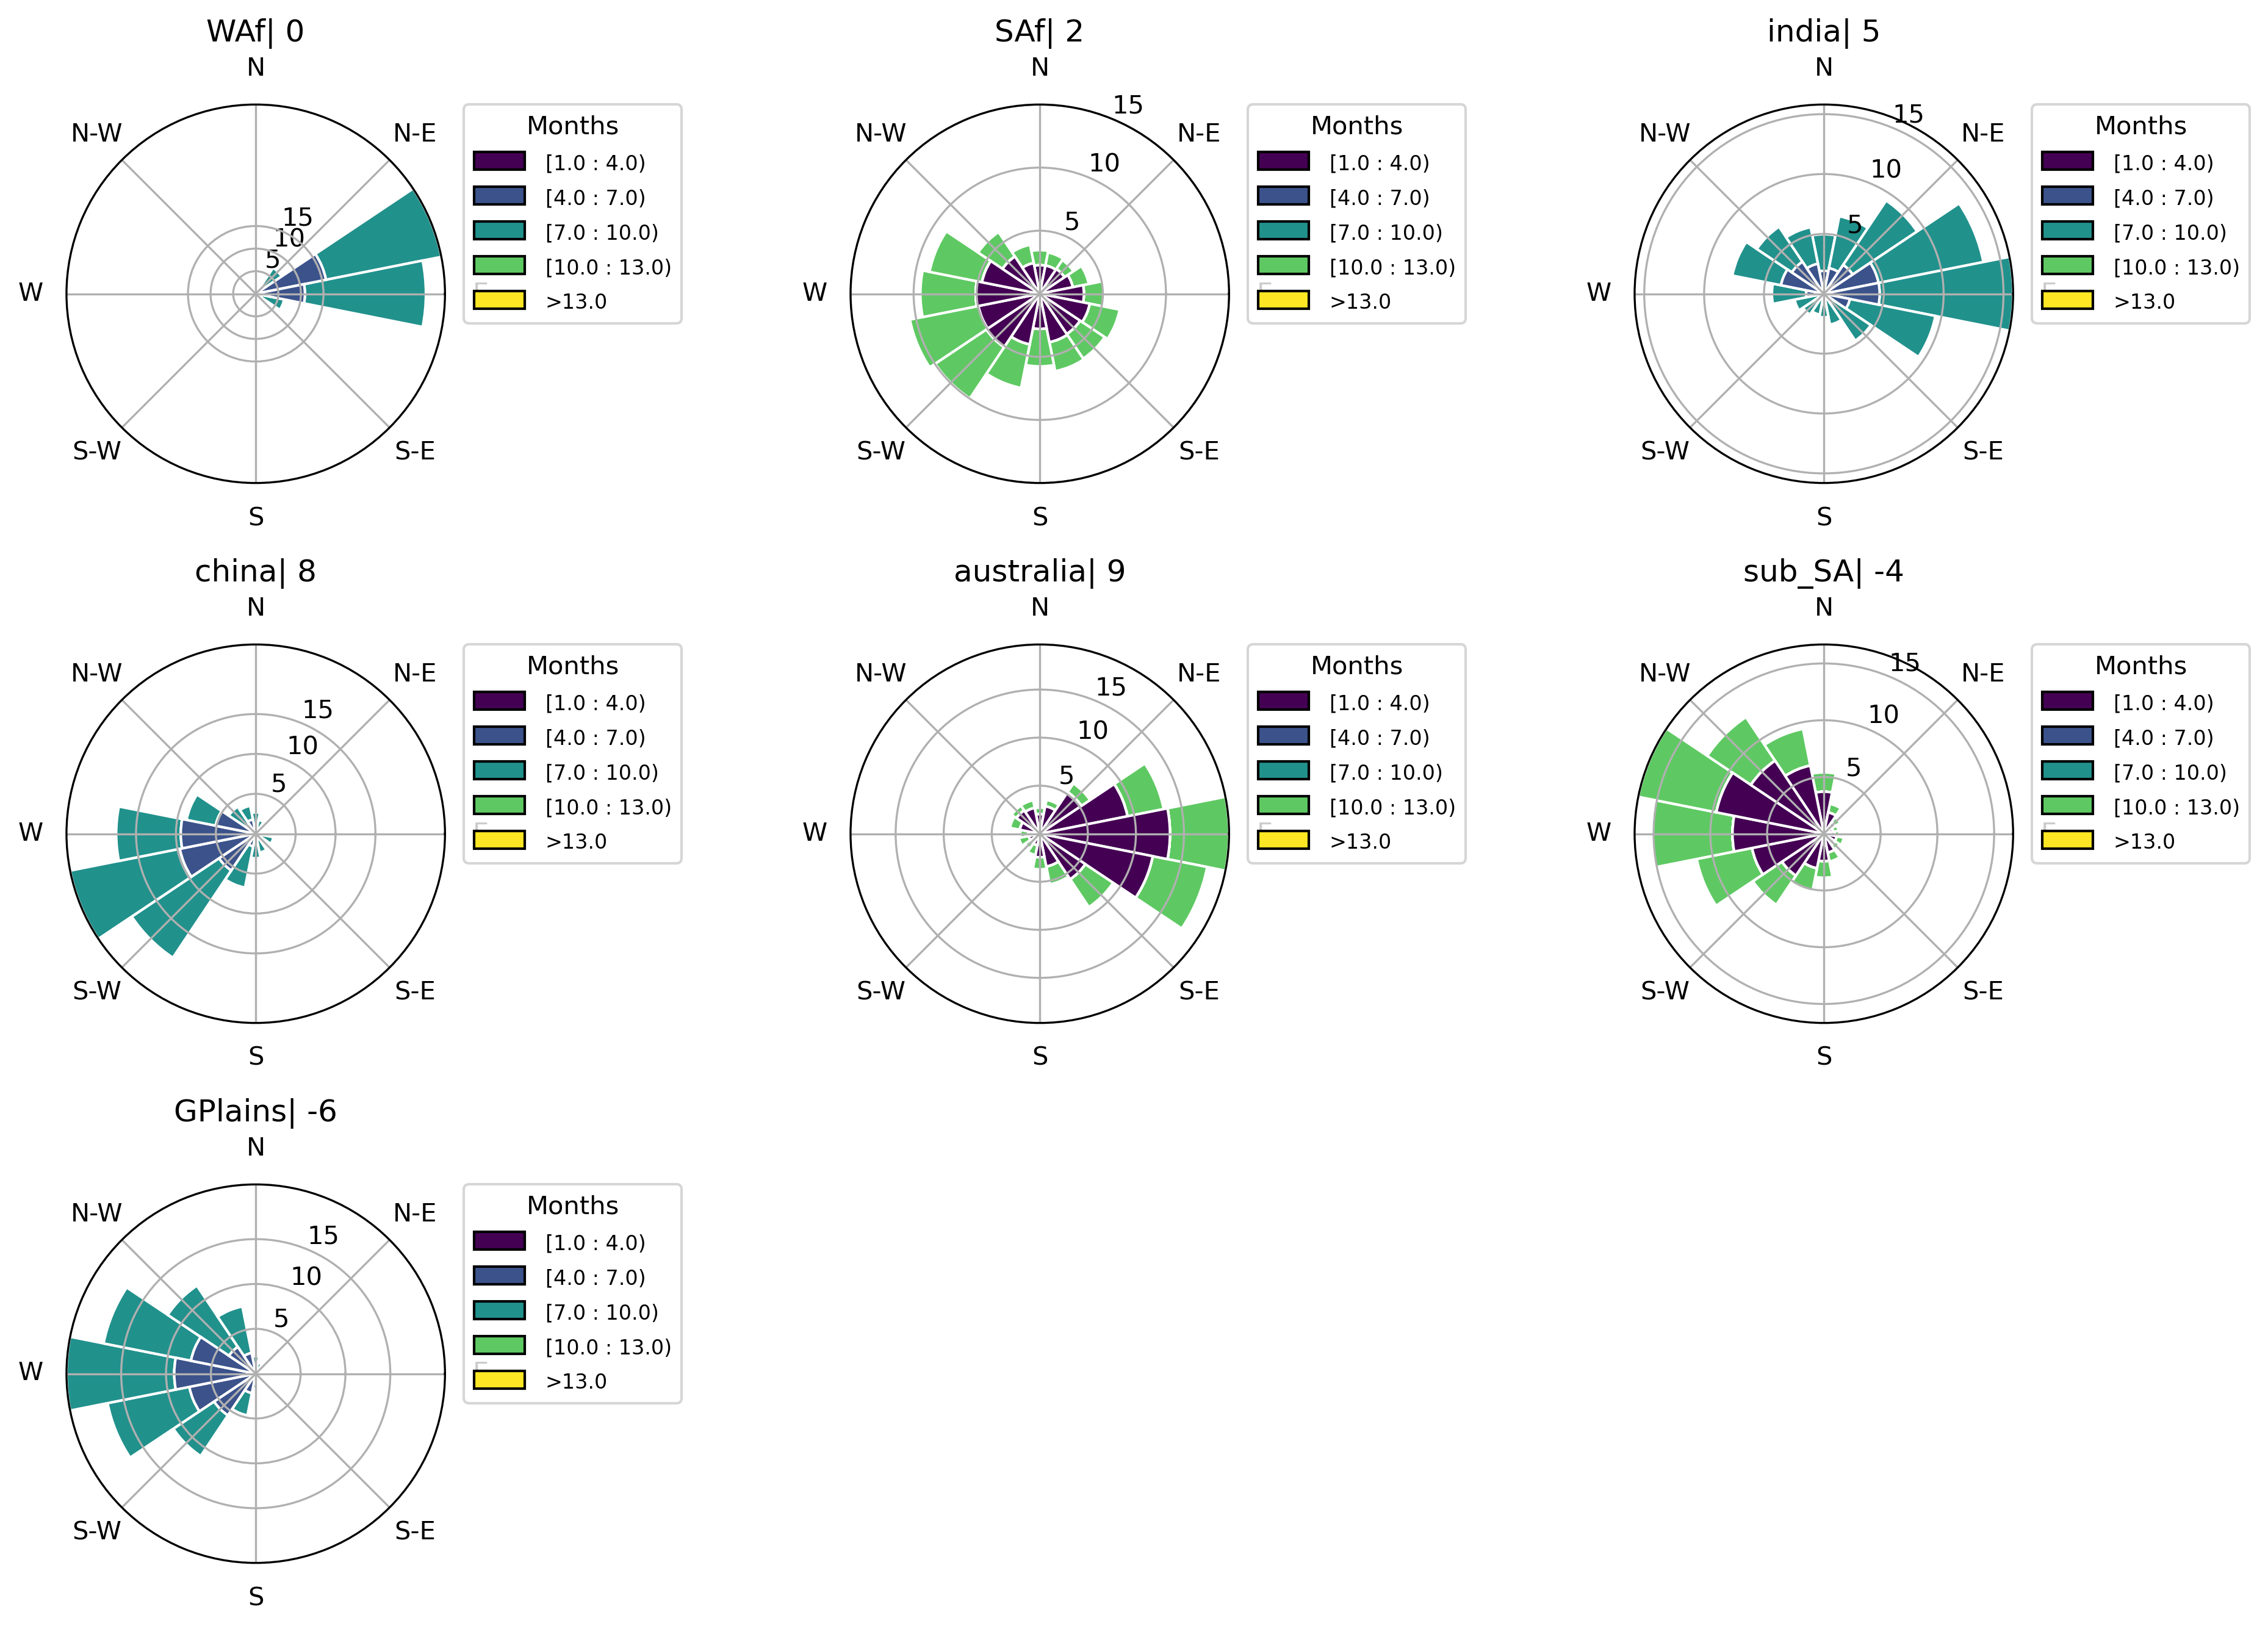

In [74]:
MREGIONS = {'WAf' : [[-18,25,4,25], 'spac', 0, (1,7), (5,9), (1,12)], # last is hourly offset to UCT # 12    # [-18,25,4,25]
 'SAf' : [[20,35, -35,-15], 'spac', 2, (9,12), (11,3), (11,3)], # 10
 'india' : [[70,90, 5,30], 'asia', 5, (1,7), (5,9), (1,12)], # 7
 'china' : [[105,115,25,40], 'asia', 8 , (1,7), (5,9), (1,12)], # 4
 'australia' : [[120,140,-23, -11], 'asia', 9, (11,3), (1,5), (1,12)], # 3
 'sub_SA' : [[-68,-47, -40, -20.5], 'spac', -4, (11,3), (1,5), (1,12)] , # 16
# 'trop_SA' : [[-75, -50, -20, -5], 'spac', -5, (1,12), (1,12), (1,12)], # 17
 'GPlains' : [[-100,-90,32,47], 'nam', -6, (1,7), (5,9), (1,12)] # # 18

}

f= plt.figure(figsize=(13,9), dpi=300)
maxval = [45,30,25,40,30,35,40]

for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1,  projection='windrose')
    
    pick = (rdics[regs])
    #pick = pick[(pick['utc_month']>=11) | (pick['utc_month']<=2)]

    umean = (pick['ushear100m_650'])
    vmean = (pick['vshear100m_650'])
    
    ws, avg_wd = u_met.u_v_to_ws_wd(umean,vmean)
    
    direct = avg_wd
    
    #####################
    ws_array2 = pick['utc_month']  #np.array(wsin.flatten())
    wd_array2 = direct

    ax = WindroseAxes.from_ax(ax)
    ax.bar(wd_array2, ws_array2, normed=True, opening=1.0, edgecolor='white', bins=[1,4,7,10,13])  #, colors=color_s[0:5]
    ax.set_yticks(np.arange(5, 20, step=5))
    ax.set_yticklabels(np.arange(5, 20, step=5))



    ax.set_title(regs + '| '+str((MREGIONS[regs])[2]))
    ax.set_legend(title = 'Months', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_mint_dist.jpg')

plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/LMCS/storm_direction_windrose_datasetV2.jpg')

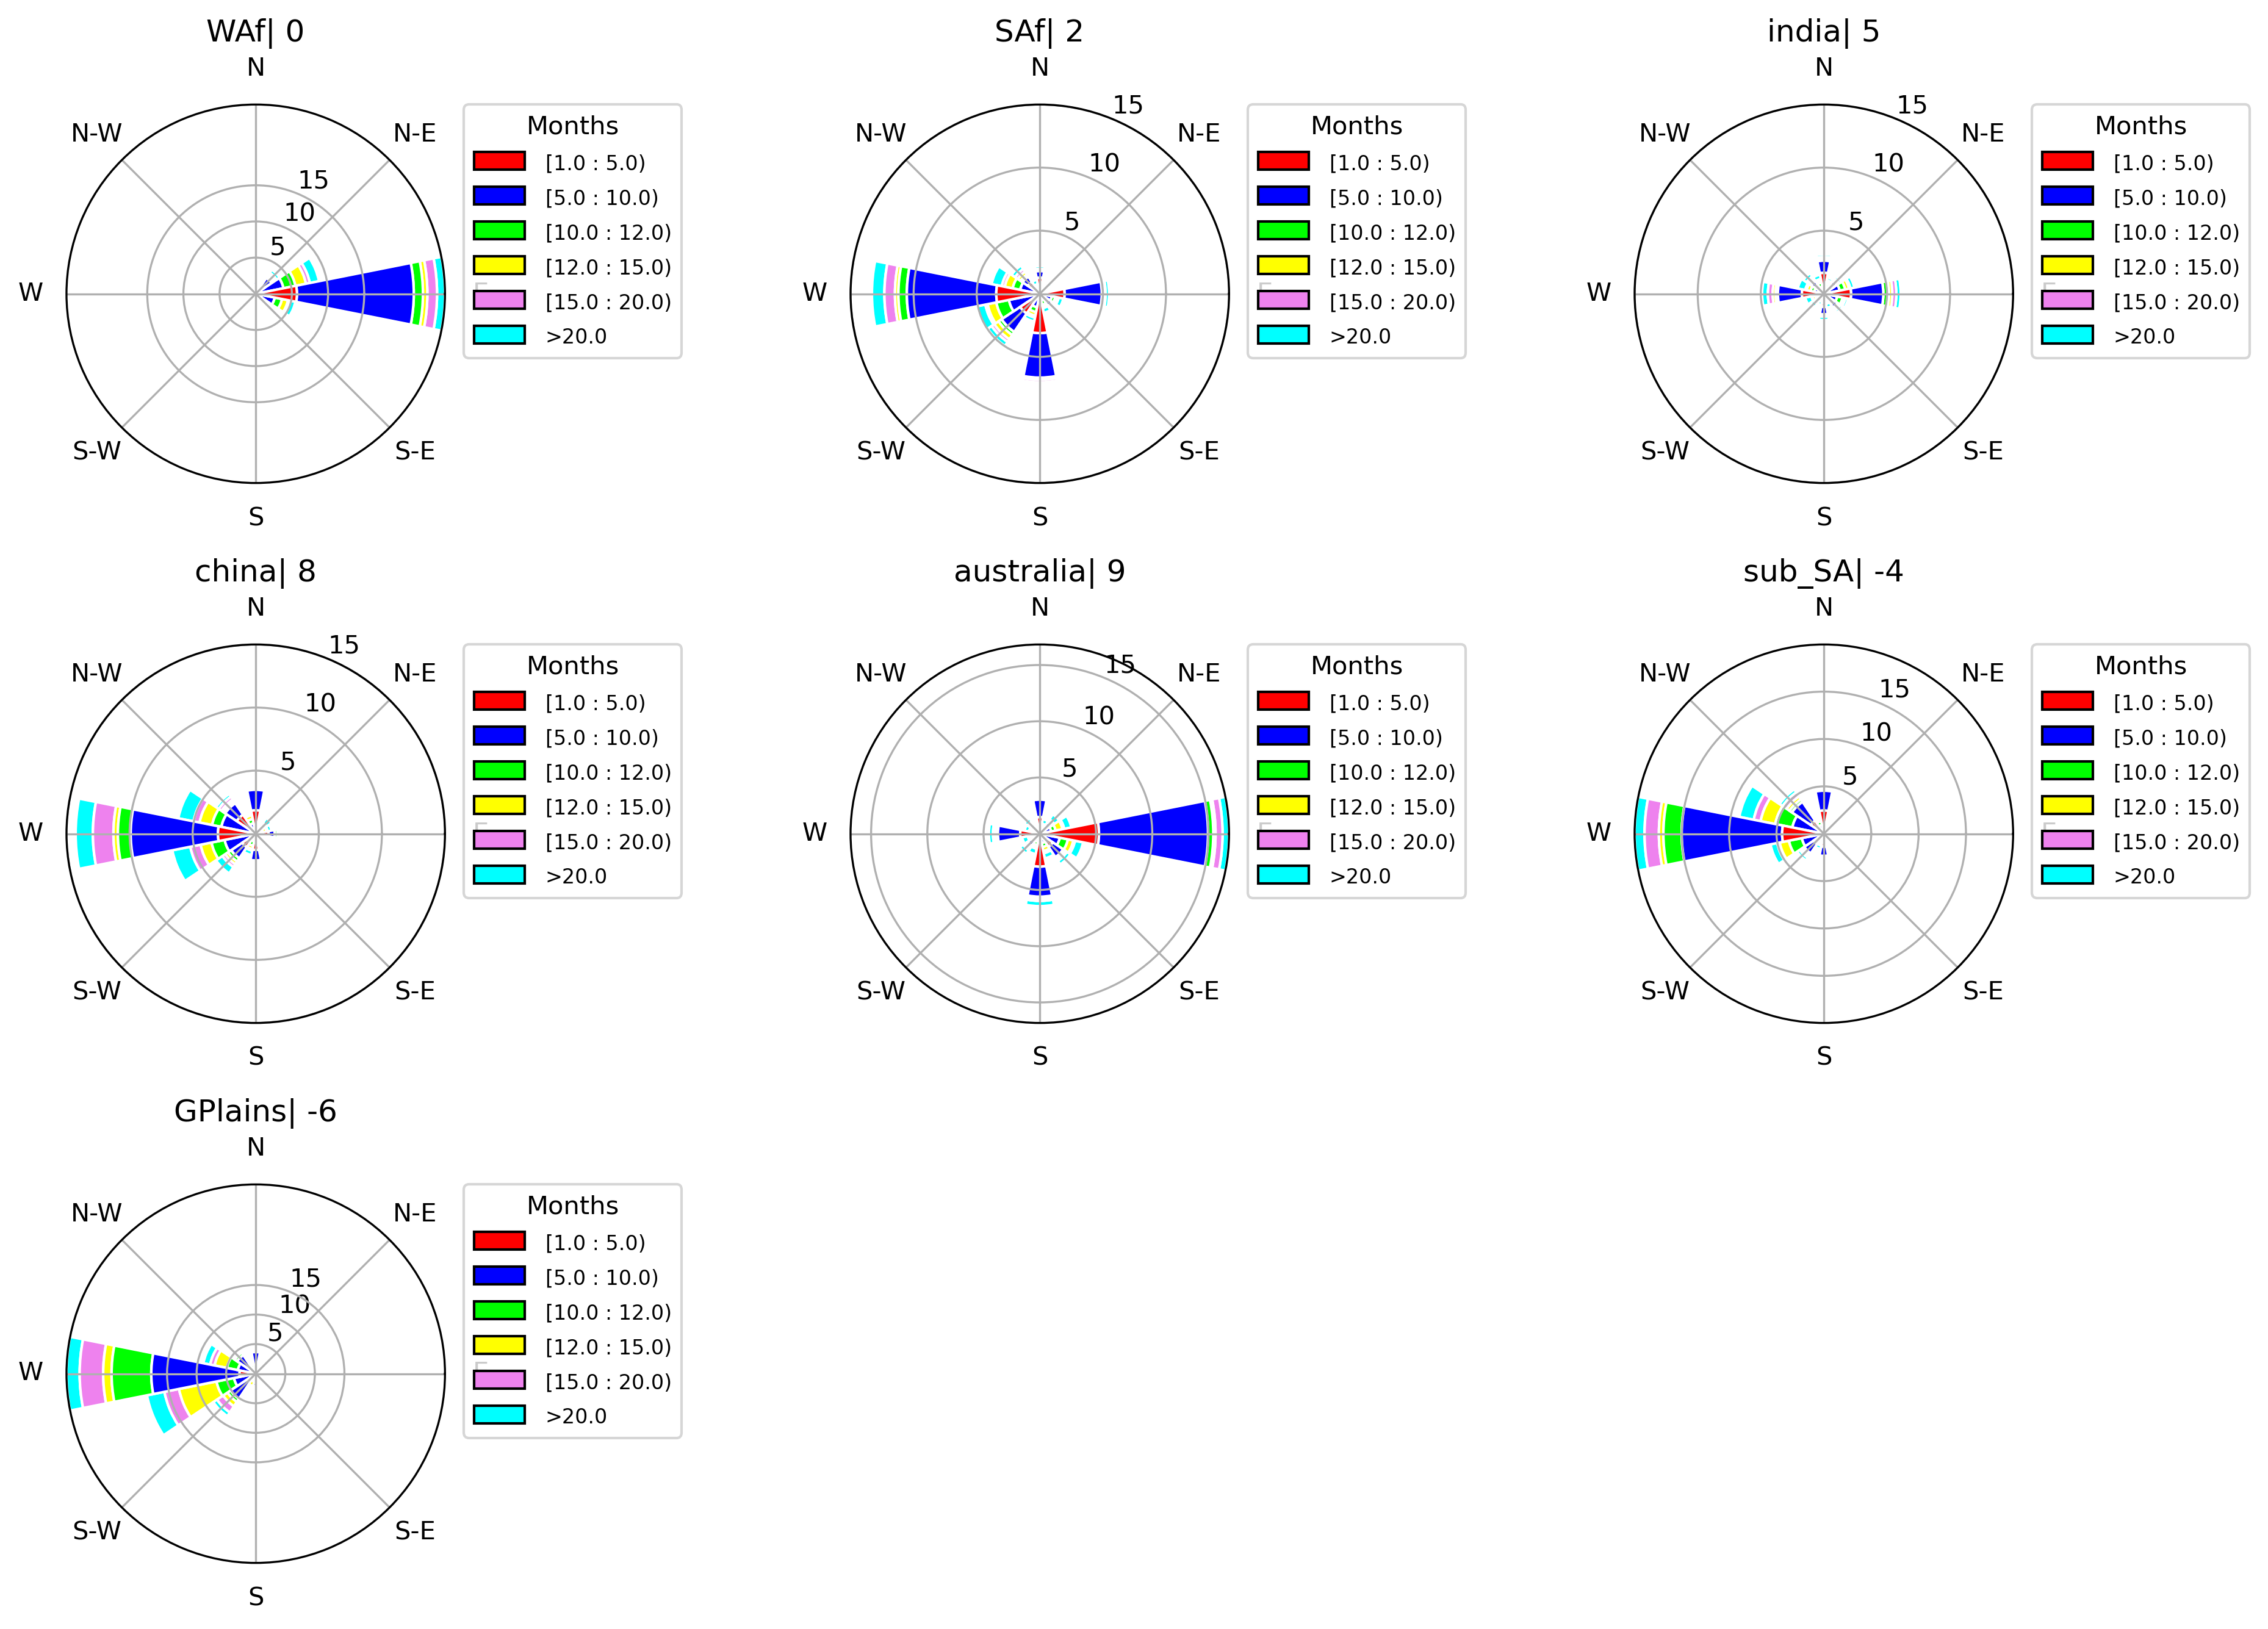

In [26]:
f= plt.figure(figsize=(13,9), dpi=300)
maxval = [45,30,25,40,30,35,40]

for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1,  projection='windrose')
    
    pick = (rdics[regs])
    #pick = pick[(pick['utc_month']>=11) | (pick['utc_month']<=2)]

    umean = (pick['movement_distance_x'])
    vmean = (pick['movement_distance_y'])
    
    ws, avg_wd = u_met.u_v_to_ws_wd(umean,vmean)
    
    direct = avg_wd
    
    #####################
    ws_array2 = ws * 1000 / 60 / 60 #np.array(wsin.flatten())
    wd_array2 = direct

    ax = WindroseAxes.from_ax(ax)
    ax.bar(wd_array2, ws_array2, normed=True, opening=1.0, edgecolor='white', bins=[1,5,10,12,15,20], colors=color_s[0:6])
    ax.set_yticks(np.arange(5, 20, step=5))
    ax.set_yticklabels(np.arange(5, 20, step=5))



    ax.set_title(regs + '| '+str((MREGIONS[regs])[2]))
    ax.set_legend(title = 'Months', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_mint_dist.jpg')

plt.tight_layout()
#f.savefig('/home/ck/Desktop/lmcs/storm_direction_windrose.jpg')

/home/ck/miniconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1555: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


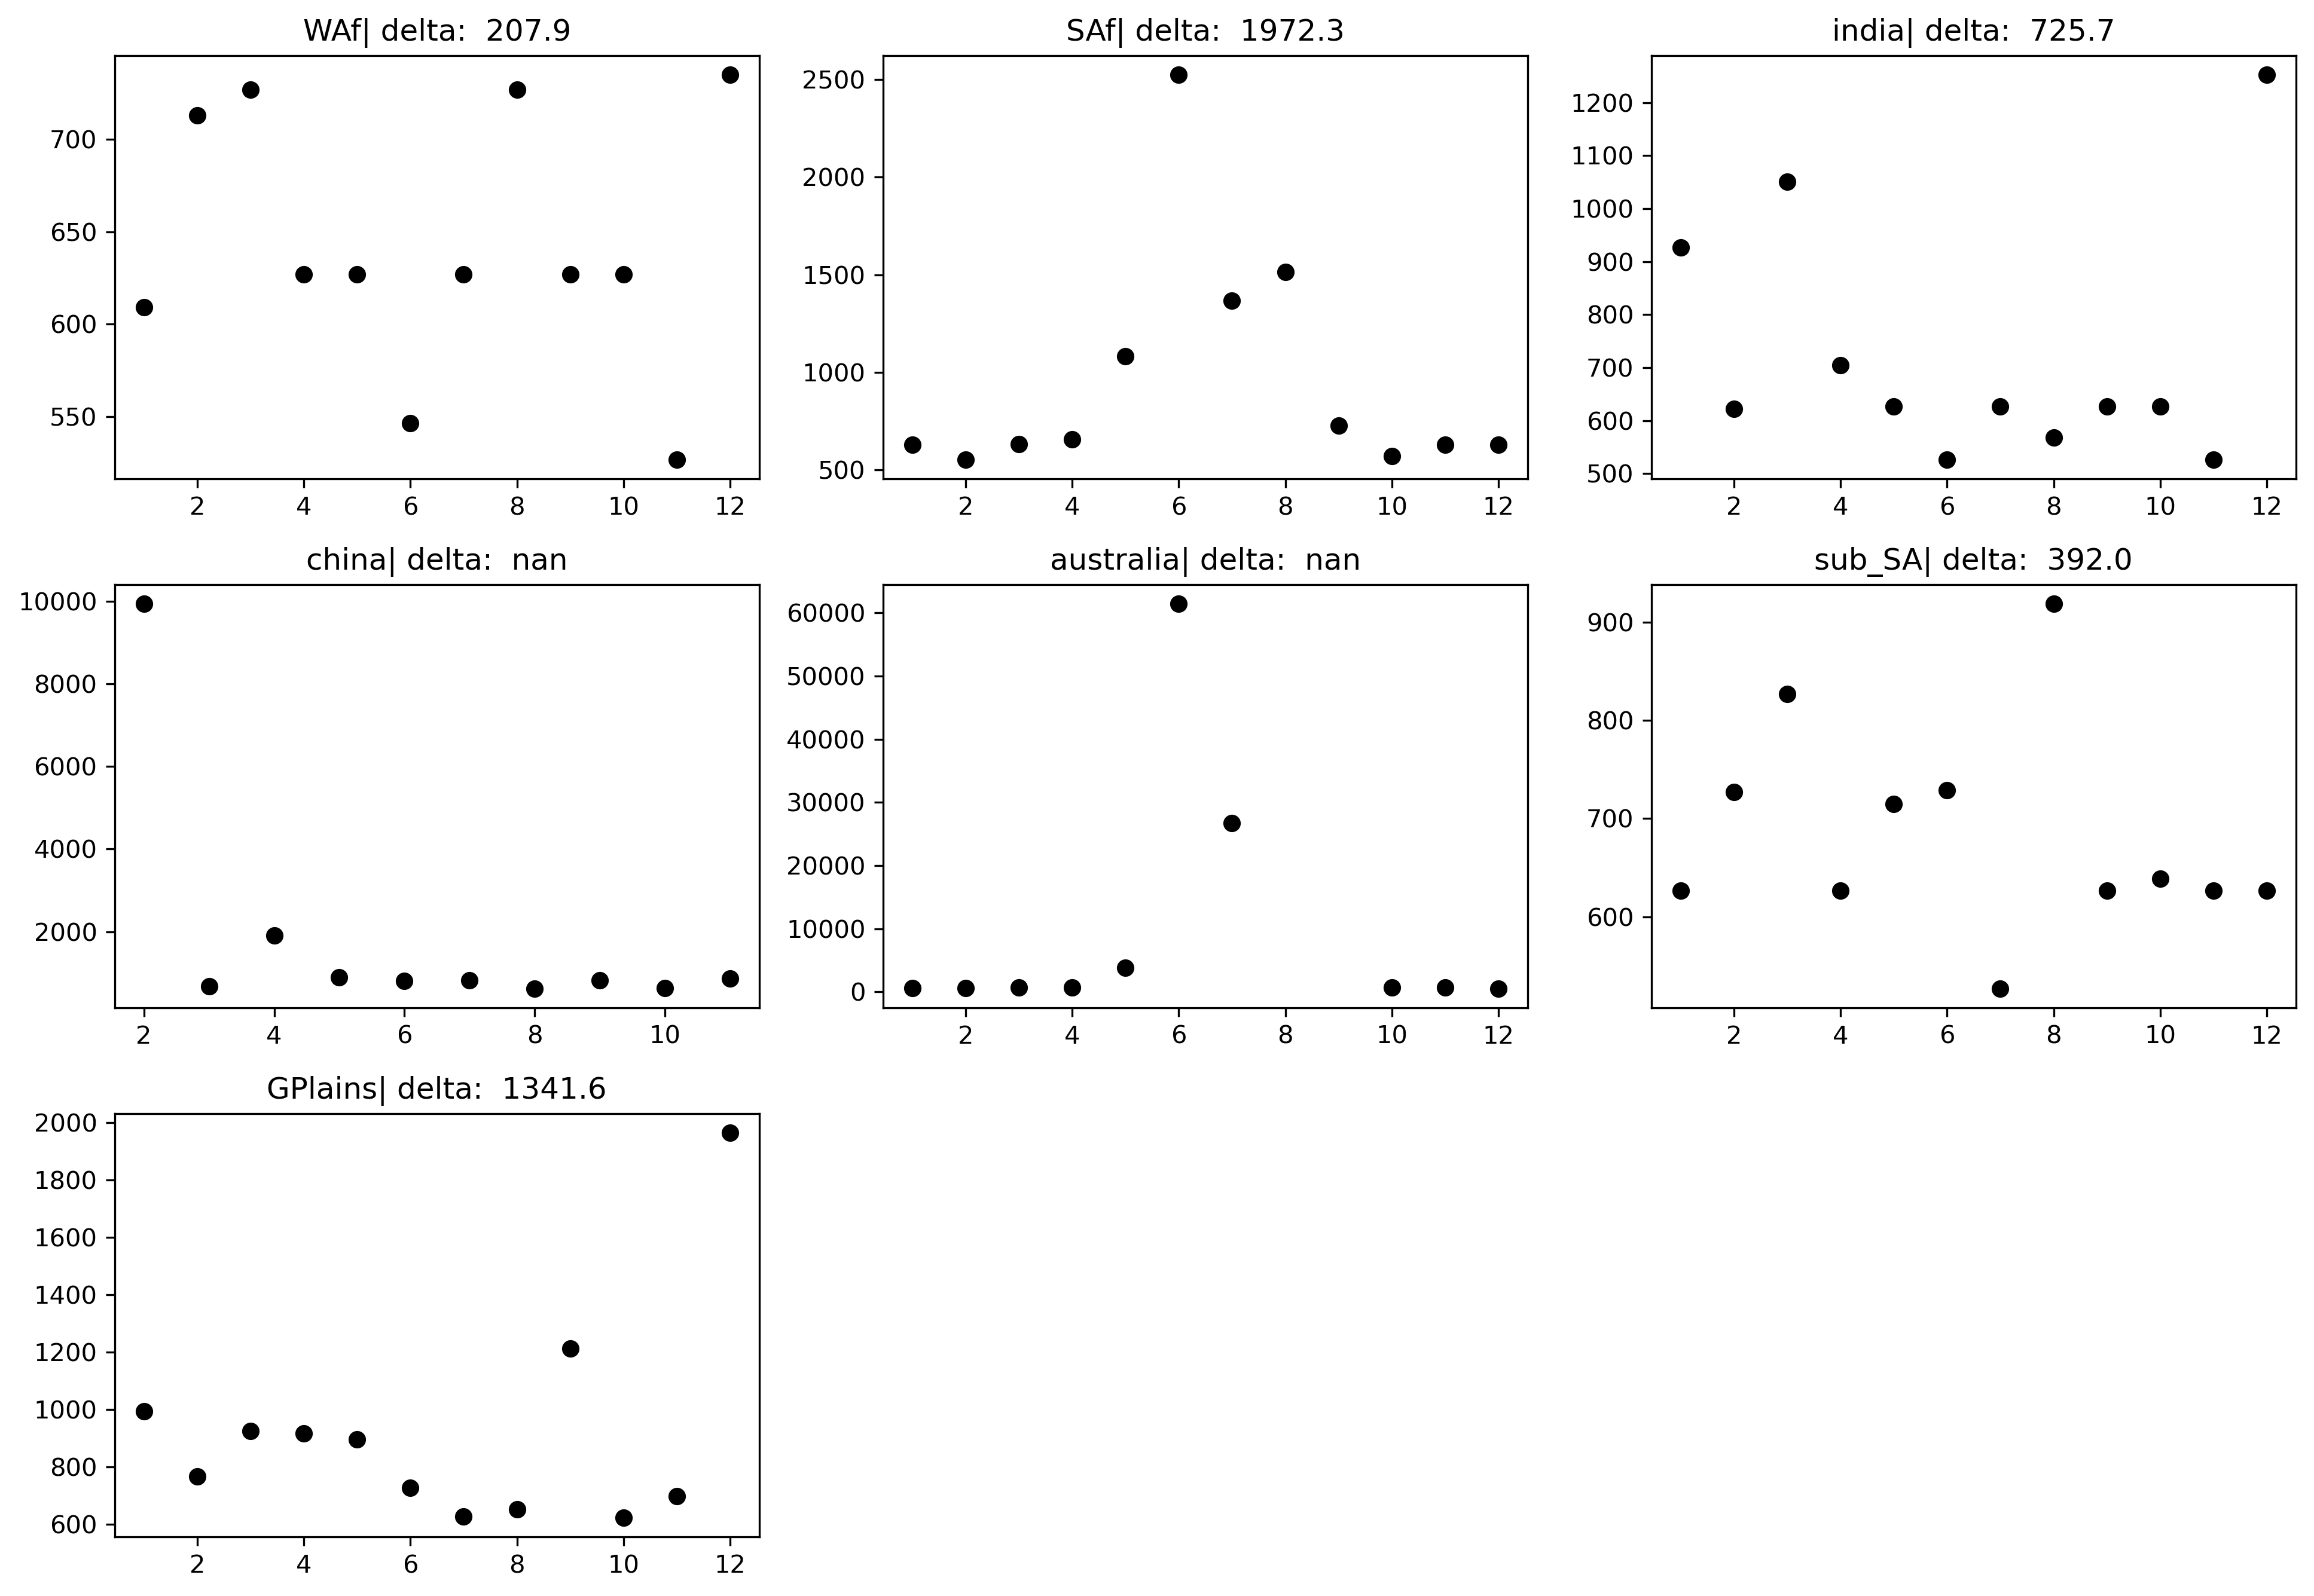

In [53]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    

    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    coll = []
    for m in range(1,13):
        pickm = pick[pick['utc_month'] == m]
        meant =  np.nanpercentile(pickm['pf_area1'].values, 0.99)
        coll.append(meant)
     
        
    ax.scatter(range(1,13),np.array(coll)-273.15, color='k')
    ax.set_title(regs + '| delta:  '+str(np.round(np.array(coll).max()-np.array(coll).min(),1)))
plt.tight_layout()
#f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_area.jpg')

In [ ]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    

    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    coll = []
    for m in range(1,13):
        pickm = pick[pick['month'] == m]
        meant =  pickm['meantb'].mean()
        coll.append(meant)
     
        
    ax.scatter(range(1,13),np.array(coll)-273.15, color='k')
    ax.set_title(regs + '| delta:  '+str(np.round(np.array(coll).max()-np.array(coll).min(),1)))
plt.tight_layout()
#f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_meant.jpg')

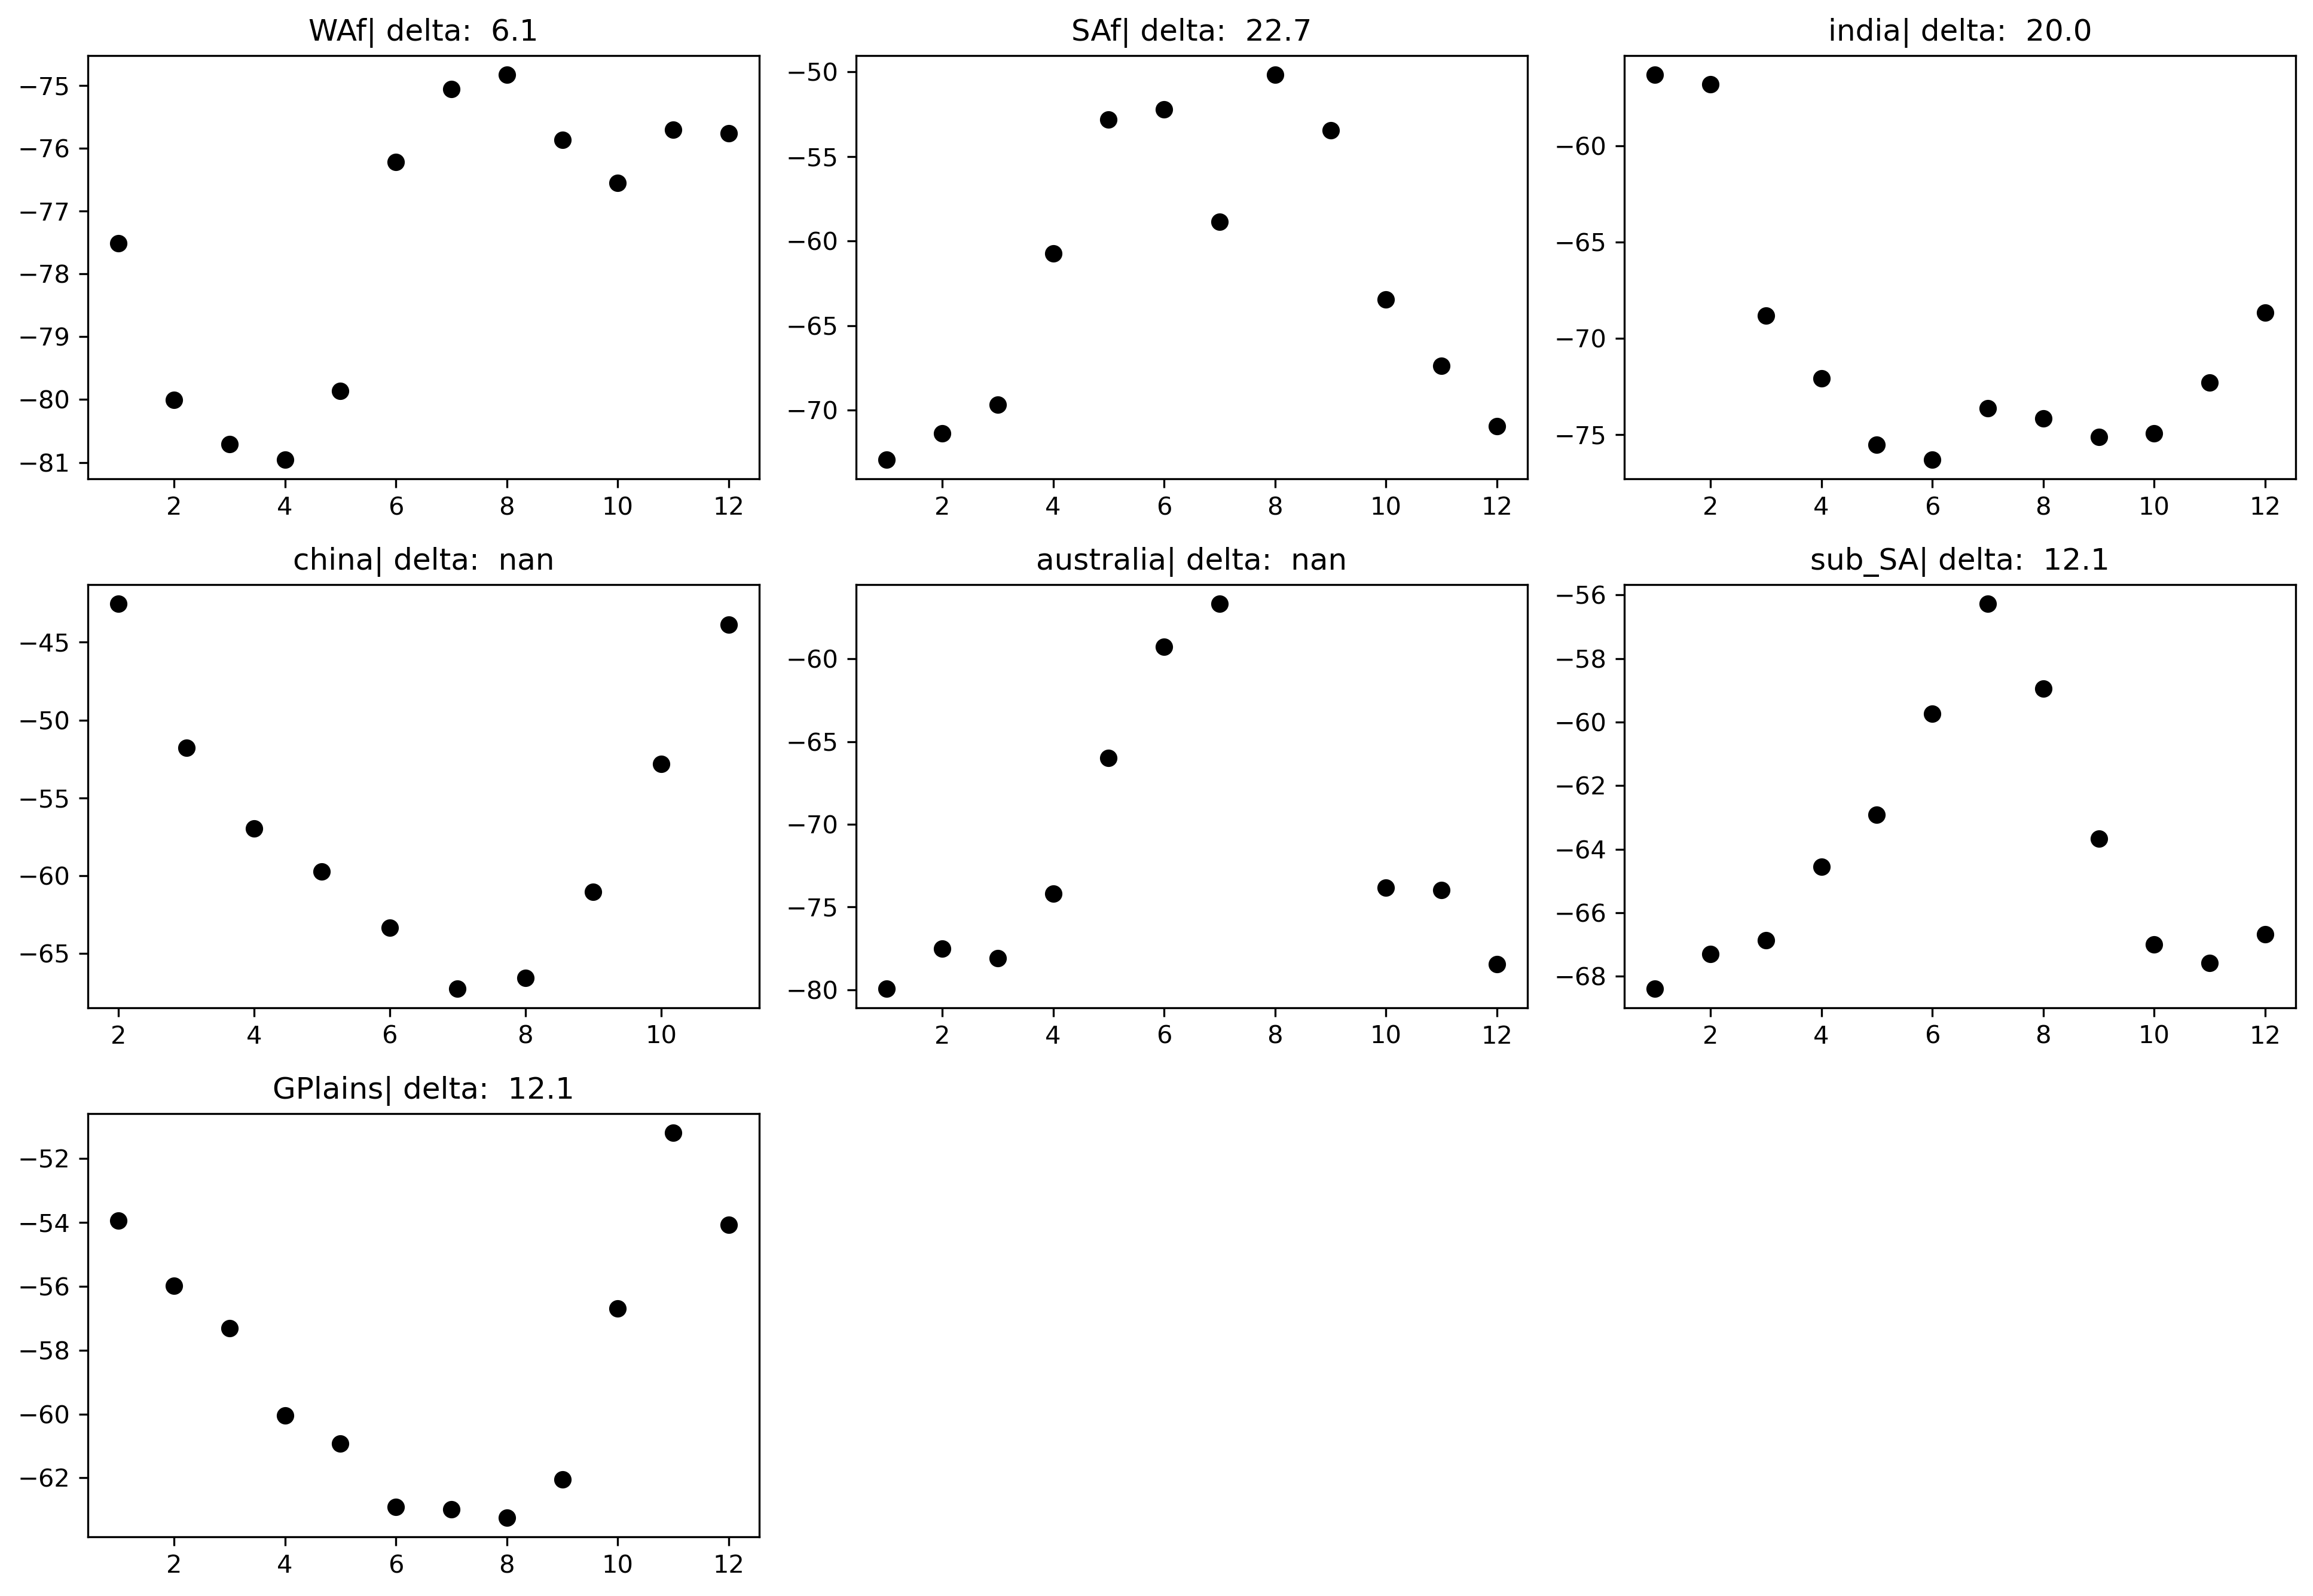

In [54]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    

    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    coll = []
    for m in range(1,13):
        pickm = pick[pick['utc_month'] == m]
        meant =  pickm['corecold_mintb'].mean()
        coll.append(meant)
     
        
    ax.scatter(range(1,13),np.array(coll)-273.15, color='k')
    ax.set_title(regs + '| delta:  '+str(np.round(np.array(coll).max()-np.array(coll).min(),1)))
plt.tight_layout()
#f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_mint.jpg')

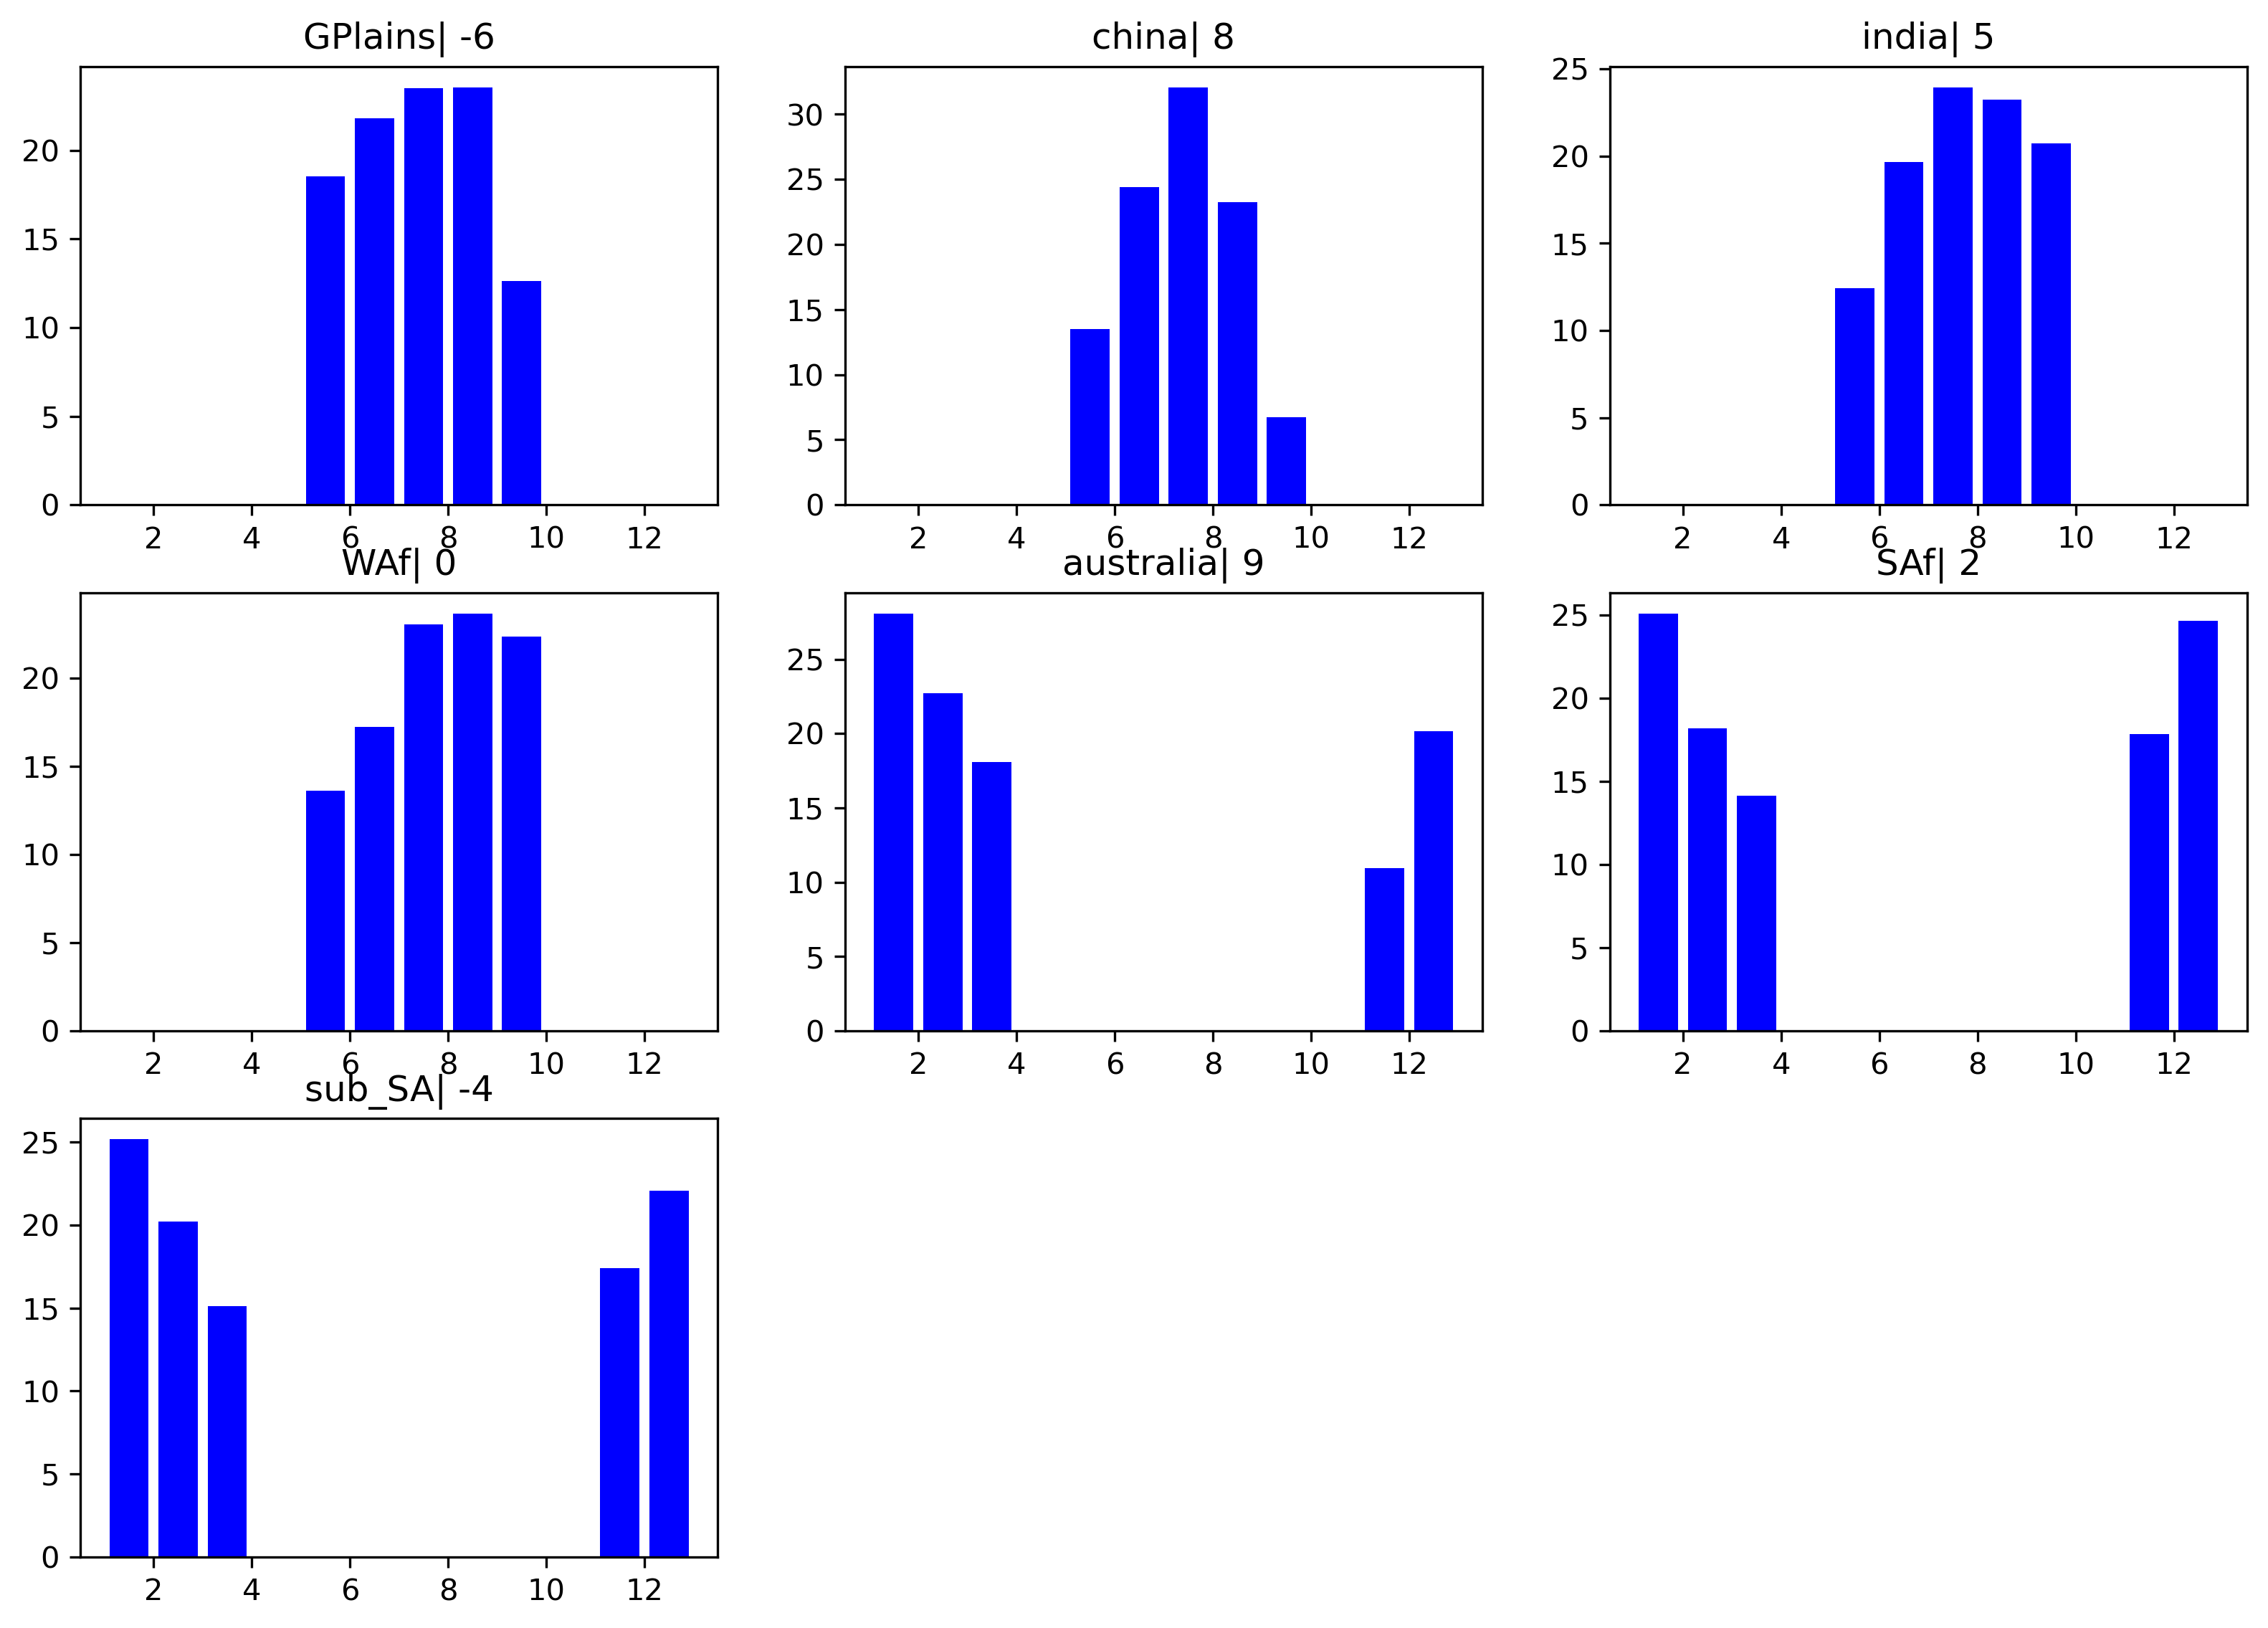

In [70]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    hist_freq, hist_count, bin_edge = u_stats.histo_frequency(pick['utc_month'], bins=np.arange(1,14))
    #print(np.unique(pick['hour']))
    mid_bin = bin_edge[0:-1] + (bin_edge[1::]-bin_edge[0:-1])/2
    #m_bin = mid_bin - (MREGIONS[regs])[2]
    #print(mid_bin)
    colors = ['b']*24
#     ispos = int(np.where(mid_bin==18.5)[0])
#     secpos = int(np.where(mid_bin==13.5)[0])
#     firstpos = int(np.where(mid_bin==10.5)[0])
#     #minpos = ispos-(MREGIONS[regs])[2]
#     #ipdb.set_trace()
#     minpos = ispos-(MREGIONS[regs])[2]
#     miinpos = firstpos - (MREGIONS[regs])[2]
#     miiinpos = secpos - (MREGIONS[regs])[2]
#     print(minpos)
#     if minpos == 24:
#         minpos=0
    
#     colors[minpos] = 'r'
#     colors[miinpos] = 'turquoise'
#     colors[miiinpos] = 'purple'
    ax.bar(mid_bin,hist_freq, align='center', color=colors)
    ax.set_title(regs + '| '+str((MREGIONS[regs])[2]))
#f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_stormNB.jpg')

18
16
13
10
9
22
24


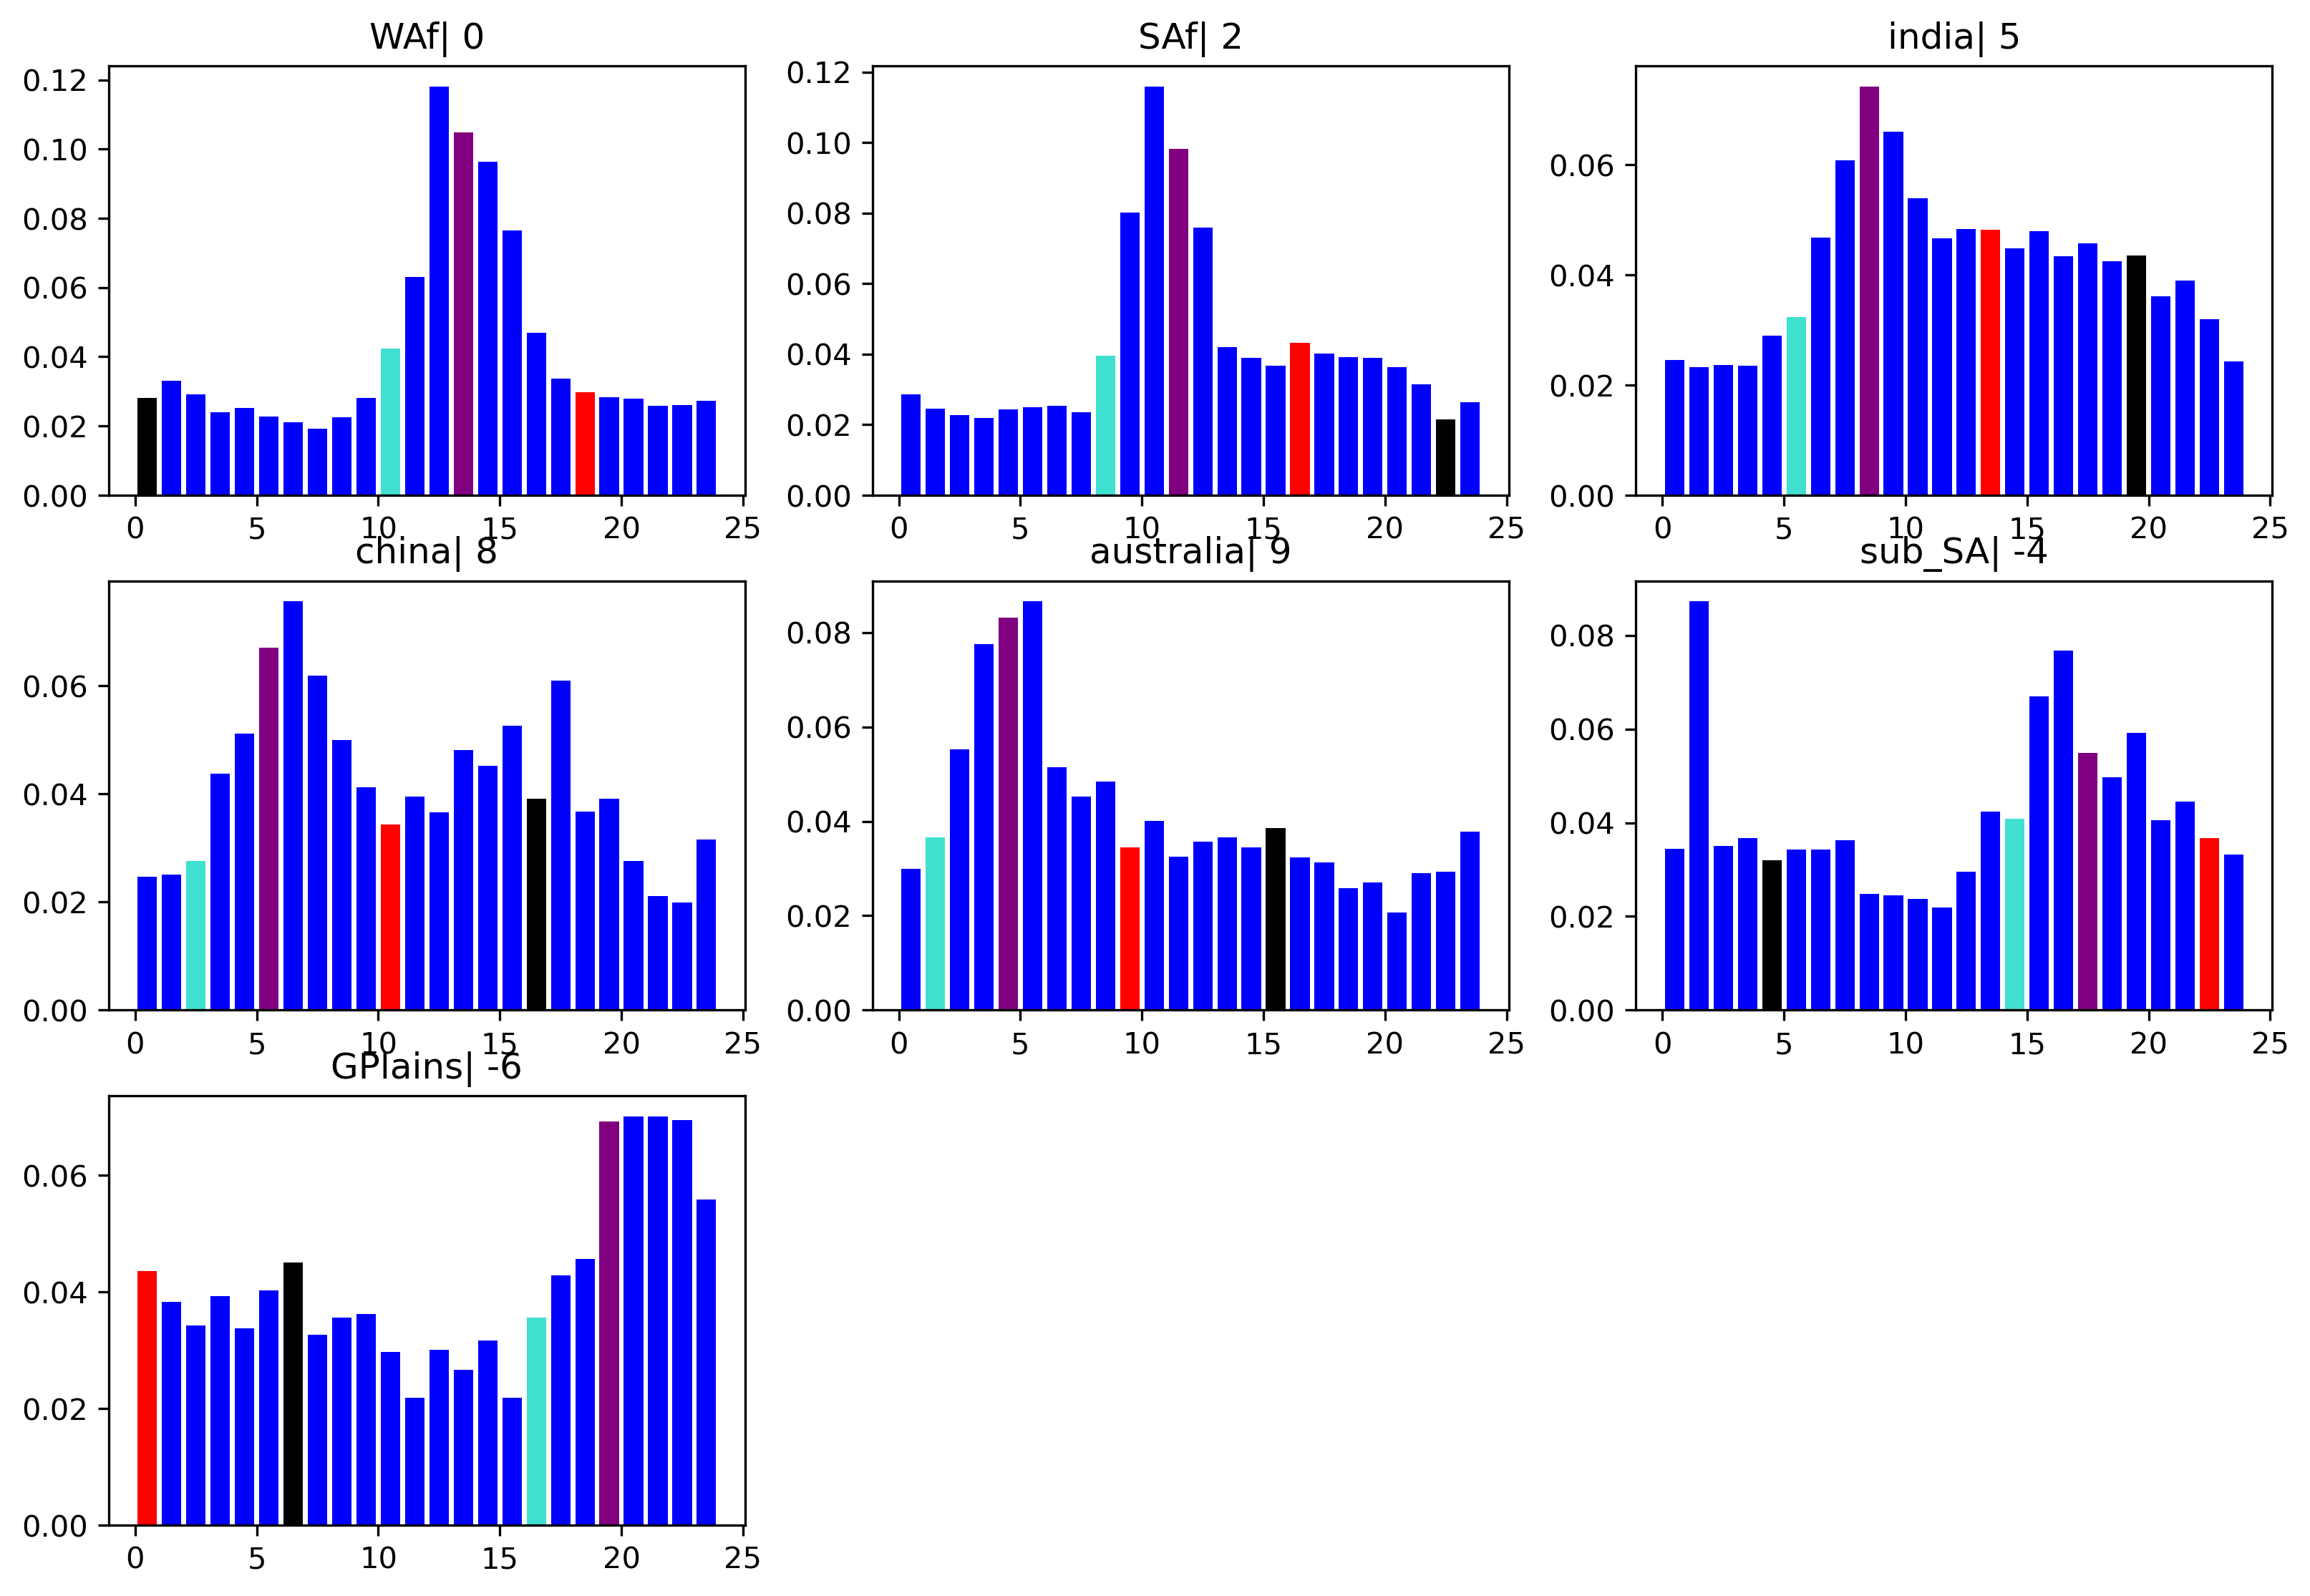

In [14]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    hist_freq, hist_count, bin_edge = u_stats.histo_frequency(pick['init_hour'], bins=np.arange(0,25))
    #print(np.unique(pick['hour']))
    mid_bin = bin_edge[0:-1] + (bin_edge[1::]-bin_edge[0:-1])/2
    #m_bin = mid_bin - (MREGIONS[regs])[2]
    #print(mid_bin)
    colors = ['b']*24
    ispos = int(np.where(mid_bin==18.5)[0])
    secpos = int(np.where(mid_bin==13.5)[0])
    firstpos = int(np.where(mid_bin==10.5)[0])
    thirdpos = int(np.where(mid_bin==0.5)[0])
    #minpos = ispos-(MREGIONS[regs])[2]
    #ipdb.set_trace()
    minpos = ispos-(MREGIONS[regs])[2]
    miinpos = firstpos - (MREGIONS[regs])[2]
    miiinpos = secpos - (MREGIONS[regs])[2]
    midnightpos = thirdpos - (MREGIONS[regs])[2]
    print(minpos)
    if minpos == 24:
        minpos=0
    
    colors[minpos] = 'r'
    colors[miinpos] = 'turquoise'
    colors[miiinpos] = 'purple'
    colors[midnightpos] = 'k'
    ax.bar(mid_bin,hist_freq, align='center', color=colors)
    ax.set_title(regs + '| '+str((MREGIONS[regs])[2]))


In [107]:
def create_dic(dic):
    
    tt = np.array(dic['tmin'])
    mask = np.where(tt<=-50)
    
    pp = np.array(dic['pmax'])[mask] 
    sh = np.array(dic['shear'])[mask]  # 925-650 hPa shear
    umin = np.array(dic['u650'])[mask] # minimum 650hPa zonal wind 
    umax = np.array(dic['u925'])[mask] # maximum 925hPa zonal wind
    qq = np.array(dic['q925'])[mask]   # 925hPa spec humidity
    qup = np.array(dic['q650'])[mask]  # 650hPa spec humidity
    tlow = np.array(dic['t925'])[mask] # 925hPa temperature
    tt = np.array(dic['tmin'])[mask]   # minimum cloud top temperature
    ttm = np.array(dic['tmean'])[mask] # mean cloud top temperature
    month = np.array(dic['month'])[mask] 
    hour = np.array(dic['hour'])[mask]
    year = np.array(dic['year'])[mask]
   # minute = np.array(dic['minute'])[mask]
    day = np.array(dic['day'])[mask]
    date = np.array(dic['date'])[mask]
    area = np.array(dic['area'])[mask] # -50C storm area
    lat = np.array(dic['clat'])[mask] # location of minimum temperature
    lon = np.array(dic['clon'])[mask] # location of minimum temperature
    tcwv = np.array(dic['tcwv'])[mask] # total column water vapour
    rh = np.array(dic['rh925'])[mask] # 925hPa relative humidity
    #pall = np.array(dic['p'])[mask] # precipitation field within -50C cloud area


    obs_pcp = {
        'prcp' : pp,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        'shear' : sh*-1,
        'month' : month,    
        'hour' : hour,
        'year' : year,
      #  'minute' : minute,
        'day' : day,
        'date' : date,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'rh' : rh,
        'tcwv' : tcwv,
        'lat' : lat,
        'lon' : lon,
        #'pall' : pall
    } 
    
    obs = pd.DataFrame(obs_pcp)
    return obs



file_path = cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_5-10N_10W10E_p15_ERA0.7_fullYear*.p'
ds = glob.glob(file_path)

for ids, dss in enumerate(ds):
    data = pkl.load( open (dss, 'rb'))

    obs_gpmf_h = create_dic(data)
    if ids > 0:
        obs_gpmf = pd.concat([obs_gpmf, obs_gpmf_h])
    else:
        obs_gpmf = obs_gpmf_h

    del data
obs = obs_gpmf[obs_gpmf.prcp>5]
obs = pd.DataFrame(obs)

In [113]:
obs

prcp       q925      q650       t925      shear  month  hour  year  \
0      7.657979  14.724190  4.140953  25.701318   6.841075      1    17  2007   
2     15.055140  14.724190  4.140953  25.701318   6.841075      1    18  2007   
3      5.943133  15.173133  4.058833  25.401636   5.112180      1    17  2007   
4     36.356035  16.458932  5.158984  23.484399  10.712464      1    17  2007   
5      7.684593  16.889343  4.339702  21.651758  11.828568      1    16  2007   
...         ...        ...       ...        ...        ...    ...   ...   ...   
2672  12.618616  17.474011  4.316392  22.397241   9.893822     12    17  2008   
2673  12.350243  16.071051  4.687850  23.121545   9.465675     12    17  2008   
2674  44.925868  16.082516  6.127825  20.624200   7.371384     12    17  2008   
2675  43.569980  16.232213  5.767504  22.369257   8.320564     12    17  2008   
2676  15.919731  15.813913  6.596897  21.096826   9.652899     12    18  2008   

      day                date   area       tmin         rh       tcwv  \
0      28 2007-01-28 17:30:00   6325 -75.300844  65.575134  38.754639   
2      28 2007-01-28 18:30:00  11500 -69.499090  65.575134  38.754639   
3      29 2007-01-29 17:30:00   5975 -72.302664  68.002640  40.713509   
4      29 2007-01-29 17:30:00   9325 -63.217142  84.037170  44.086544   
5      31 2007-01-31 16:00:00  12050 -78.338737  96.645584  51.395821   
...   ...                 ...    ...        ...        ...        ...   
2672   17 2008-12-17 17:00:00   5650 -81.180647  95.546036  48.703316   
2673   17 2008-12-17 17:00:00   5350 -76.991820  83.916214  48.527660   
2674   18 2008-12-18 17:00:00  55575 -83.975624  96.535057  52.119255   
2675   18 2008-12-18 17:00:00  13200 -77.568508  88.686577  53.128746   
2676   18 2008-12-18 18:30:00  50550 -82.000000  93.496010  55.824505   

           lat       lon  
0     7.356987 -1.882976  
2     7.404227 -2.109662  
3     6.358965 -0.271936  
4     7.397655 -7.537494  
5     5.408220 -7.923906  
...        ...       ...  
2672  5.587612  7.445095  
2673  6.088415 -0.980034  
2674  5.832236 -7.297491  
2675  5.710372 -4.322611  
2676  5.922735 -7.730055  

[21848 rows x 16 columns]

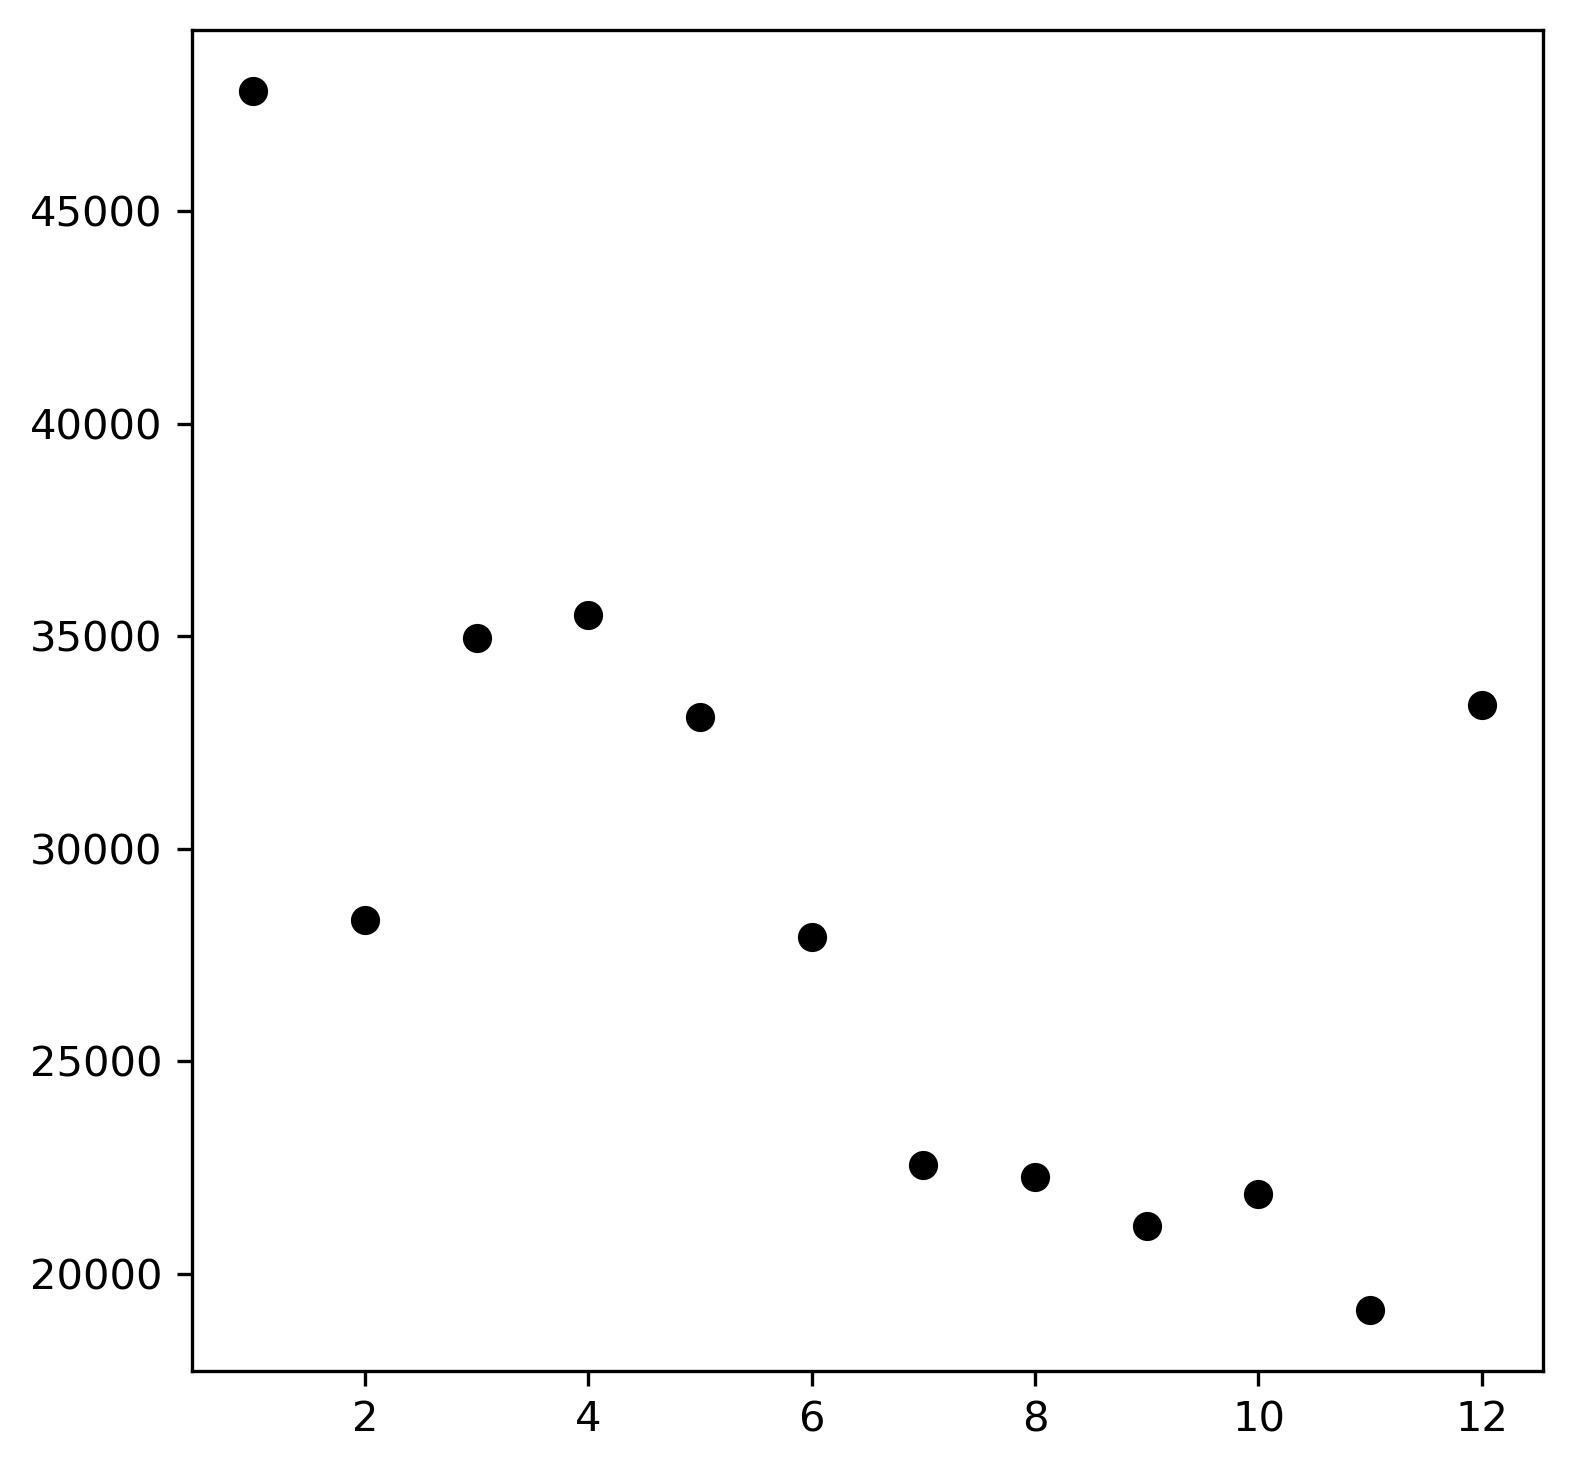

In [115]:
f= plt.figure(figsize=(10,5), dpi=300)

ax = f.add_subplot(1,2,1)
    
pick =obs
coll = []
for m in range(1,13):
    pickm = pick[pick['month'] == m]
    meant =  pickm['area'].mean()
    coll.append(meant)


ax.scatter(range(1,13),np.array(coll), color='k')
#ax.set_title(regs + '| delta:  '+str(np.round(np.array(coll).max()-np.array(coll).min(),1)))
plt.tight_layout()
#f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_mint.jpg')

Text(0.5, 1.0, 'Storm area West Africa | 5000km2 min, -50C')

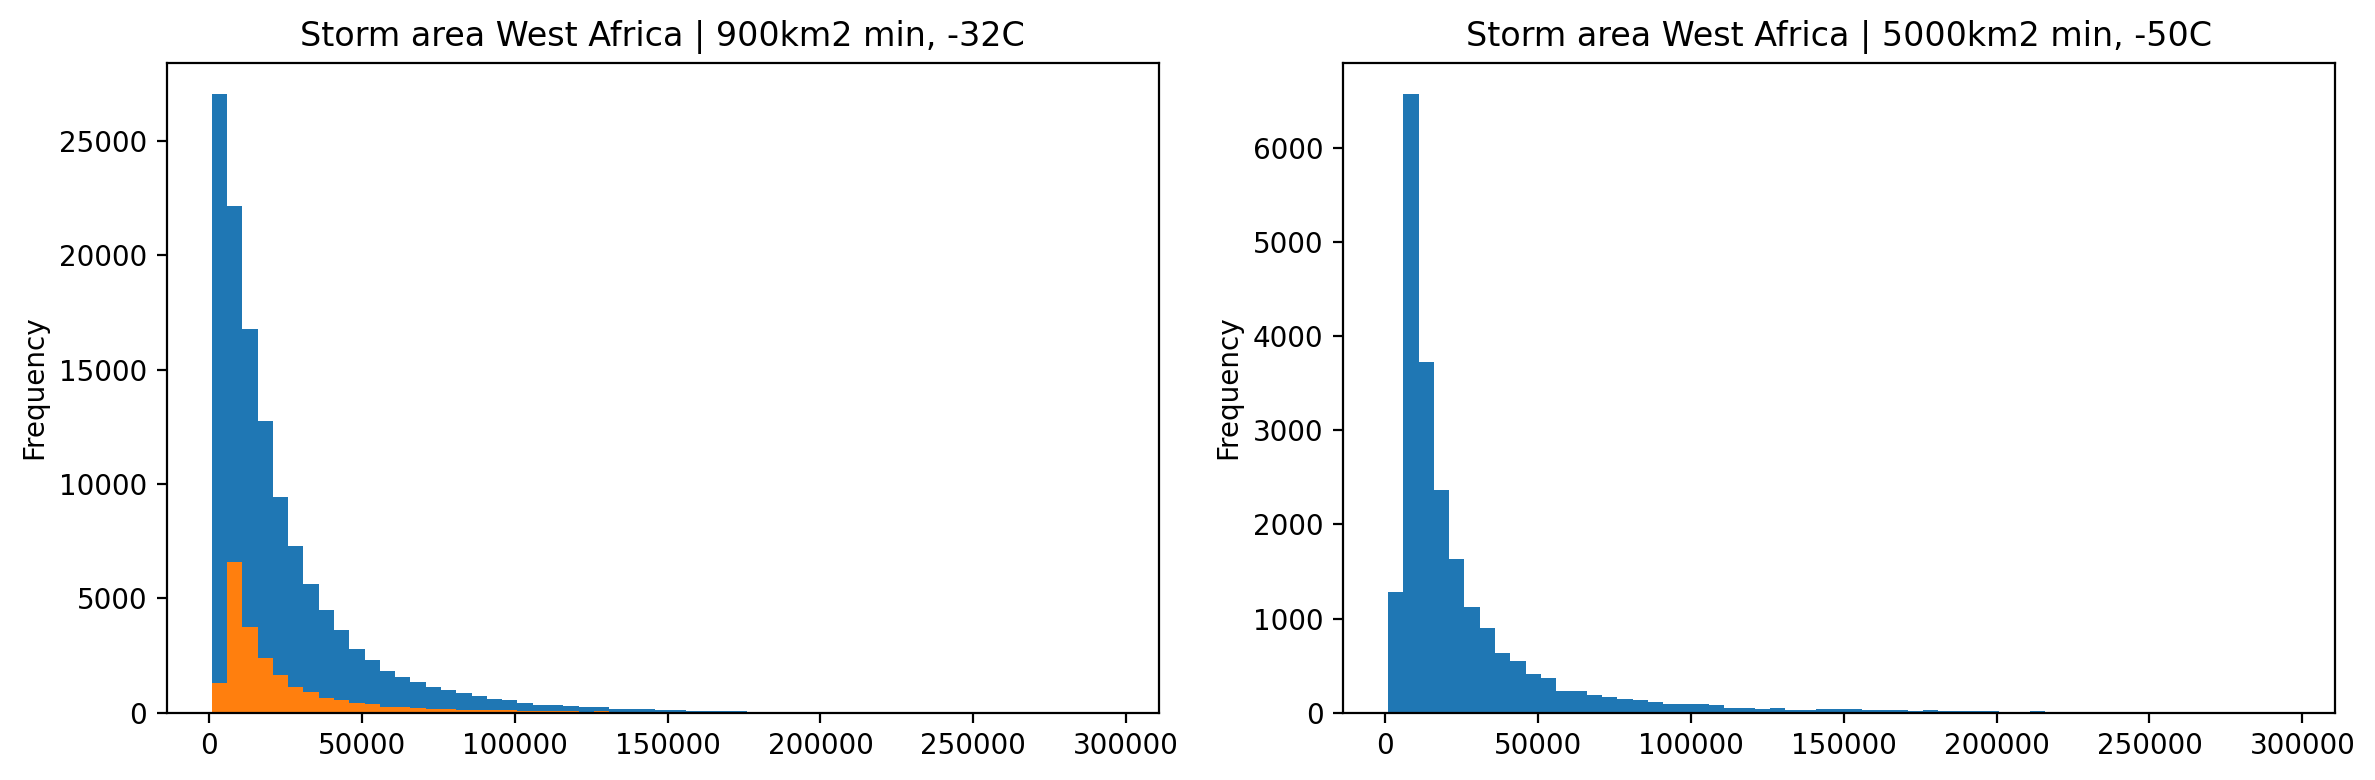

In [125]:
f = plt.figure(figsize=(12,4), dpi=200)
ax = f.add_subplot(121)
(rdics['WAf'])['pf_area1'].plot.hist(bins=range(900,300000,5000)) # ccs_area, pf_area1
plt.title('Storm area West Africa | 900km2 min, -32C')

ax = f.add_subplot(122)
(obs['area']).plot.hist(bins=range(900,300000,5000))
plt.tight_layout()
plt.title('Storm area West Africa | 5000km2 min, -50C')

Text(0.5, 1.0, 'Storm area West Africa | 5000km2 min, -50C')

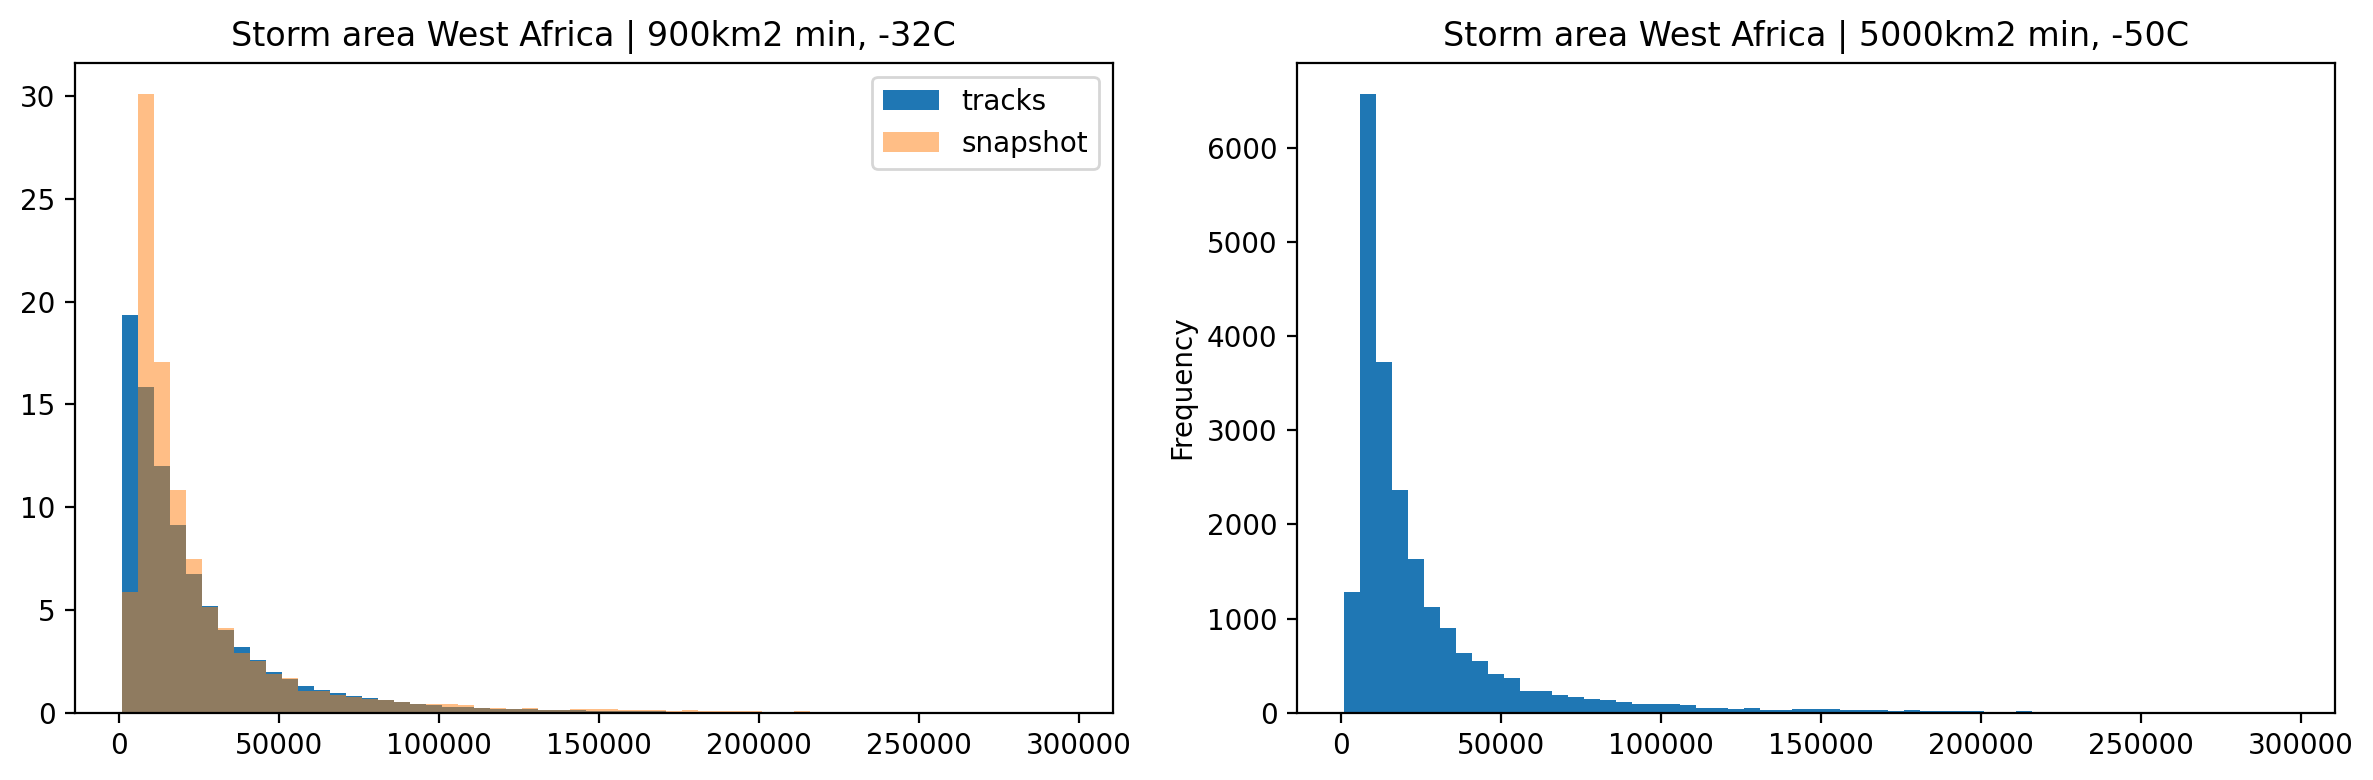

In [138]:
from utils import u_plot
f = plt.figure(figsize=(12,4), dpi=200)
ax = f.add_subplot(121)
#hist, count, h = stats.histo_frequency((rdics['WAf'])['pf_area1'], bins=range(900,300000,5000))
u_plot.hist_freq(ax, rdics['WAf']['pf_area1'], bins=range(900,300000,5000), label='tracks') # ccs_area, pf_area1
u_plot.hist_freq(ax, obs['area'], bins=range(900,300000,5000), label='snapshot', alpha=0.5) # ccs_area, pf_area1
plt.title('Storm area West Africa | 900km2 min, -32C')
#ax.set_xlim(10000,200000)
plt.legend()

ax = f.add_subplot(122)
(obs['area']).plot.hist(bins=range(900,300000,5000))
plt.tight_layout()
plt.title('Storm area West Africa | 5000km2 min, -50C')